# Ajuste del modelo logísitico a datos de COVID-19

El propósito de este *notebook* es el de ajustar, utilizando un modelo logístico, los datos disponibles de casos confirmados y muertes del coronavirus COVID-19.

**Actualización de gráficos, ajustes y registros: 27.07.2020**

Este *notebook* puede ejecutarse dinámicamente con Binder:
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/manuxch/logistic-covid19/master?filepath=Logistic_model_COVID-19.ipynb)

In [1]:
# Módulos necesarios
import csv  # manejo de archivos csv
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt  # gráficos
import matplotlib.cm as cm  # paletas de colores
from matplotlib.lines import Line2D  # markers
import math
import requests  # accede a datos online
import numpy as np  # numpy!
from scipy.optimize import curve_fit  # ajuste de datos
import warnings
from scipy.optimize import OptimizeWarning

## Acceso a datos

Los datos a utilizar son los provistos por el *Center for Systems Science and Engineering* (CSSE) de *Johns Hopkins University* (JHU), disponibles en su repositorio de [GitHub](https://github.com/CSSEGISandData/COVID-19). 

Los datos a ajustar son los de la cantidad de casos confirmados y el número de muertes.

In [2]:
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deadths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

r_cases = requests.get(url_cases)
r_deadths = requests.get(url_deadths)

## Selección y  extracción de datos por países

Los diccionarios siguientes agrupan los países que serán analizados según si son "cercanos" o "lejanos". Los datos en los archivos originales tienen la región en la primer columna y el país en la segunda. Por eso el diccionario está compuesto por una lista con dos elementos: región y país. La clave del diccionario es como se identifica al país en los datos originales, el segundo elemento de la lista es su nombre en español.

Los datos quedan agrupados en dos diccionarios, con las claves con el nombre del país, y los valores son array de datos.

In [3]:
paises_lat = {'Argentina': ['','Argentina'], 'Brazil': ['','Brasil'], 'Chile': ['','Chile'],
                'Ecuador': ['','Ecuador'], 'Perú': ['','Perú'], 'Colombia': ['','Colombia']}
paises_no_lat = {'Spain': ['','España'], 'Italy': ['','Italia'], 'United Kingdom': ['','Reino Unido'],
                 'US': ['','Estados Unidos'], 'Germany': ['','Alemania'], 
                 'China':['Hubei','China-Hubei'], 'France': ['', 'Francia']}
paises_escandinavos = {'Denmark': ['','Dinamarca'], 'Norway': ['', 'Noruega'], 'Sweden': ['', 'Suecia'],
                       'Finland': ['', 'Finlandia'], 'Iceland': ['', 'Islandia']}
cases_csv = csv.reader(r_cases.text.strip().split('\n'))
deadths_csv = csv.reader(r_deadths.text.strip().split('\n'))
cases_lat = {}
cases_no_lat = {}
cases_scand = {}
fmt_date = '%m/%d/%y'
for record in cases_csv:
    if record[0] == 'Province/State':
        fechas = [datetime.datetime.strptime(d, fmt_date) for d in record[4:]]
    if record[1] in paises_lat.keys() and record[0] == paises_lat[record[1]][0]:
        cases = np.array([int(c) for c in record[4:]])
        cases_lat[paises_lat[record[1]][1]] = cases
    if record[1] in paises_no_lat.keys() and record[0] == paises_no_lat[record[1]][0]:
        cases = np.array([int(c) for c in record[4:]])
        cases_no_lat[paises_no_lat[record[1]][1]] = cases
    if record[1] in paises_escandinavos.keys() and record[0] == paises_escandinavos[record[1]][0]:
        cases = np.array([int(c) for c in record[4:]])
        cases_scand[paises_escandinavos[record[1]][1]] = cases        
deadths_lat = {}
deadths_no_lat = {}
deadths_scand = {}
for record in deadths_csv:
    if record[1] in paises_lat.keys() and record[0] == paises_lat[record[1]][0]:
        cases = np.array([int(c) for c in record[4:]])
        deadths_lat[paises_lat[record[1]][1]] = cases
    if record[1] in paises_no_lat.keys() and record[0] == paises_no_lat[record[1]][0]:
        cases = np.array([int(c) for c in record[4:]])
        deadths_no_lat[paises_no_lat[record[1]][1]] = cases
    if record[1] in paises_escandinavos.keys() and record[0] == paises_escandinavos[record[1]][0]:
        cases = np.array([int(c) for c in record[4:]])
        deadths_scand[paises_escandinavos[record[1]][1]] = cases
        

## Modelo de ajuste

El modelo de ajuste es el logístico. Este modelo representa la dinámica de una población que presenta un límite en el crecimiento, debido a disponibilidad limitada de recursos o, como en el caso de una población que sufre una epidemia, el aumento en la cantidad de personas contagiadas disminuye a medida que hay menos personas susceptibles de contraer el virus.

Puede verse una descripción detallada del modelo en el trabajo de Gábor Vattay: ["Predicting the ultimate outcome of the COVID-19 outbreak in Italy"](https://arxiv.org/abs/2003.07912) del 17 de marzo de 2020.

El modelo consiste en representar la dinámica de una población a través de la ecuación logística:
\begin{align}
\frac{dN(t)}{dt} = \lambda_0 \, N(t) \, \left(1 - \frac{N(t)}{N_{\infty}} \right)
\end{align}
donde $\lambda_0$ es un coeficiente relacionado con la tasa de crecimiento que depende de la cantidad de individuos de la población (ver ecuaciones 2 y 3 del *paper* citado), $N$ es la cantidad de individuos, $t$ es el tiempo, y $N_{\infty}$ en el valor límite que puede alcanzar la población.

La solución de la ecuación logística es:

\begin{align}
N(t) = \frac{N_{\infty}}{1 + \left( \frac{N_{\infty}}{N_0} - 1 \right) \, e^{- \lambda_0 \, t}}
\end{align}
donde $N_0$ es el número de individuos de la población cuando $t=0$. En este *notebook*, $N$ puede representar tanto el número de casos confirmados como el número de personas fallecidas.

Con esta expresión, se puede definir el tiempo final $t_f$ de la epidemia cuando el número de casos alcanza la fracción $(1-p)$ de los casos totales:
\begin{align}
(1-p) N_{\infty} = \frac{N_{\infty}}{1 + \left( \frac{N_{\infty}}{N_0} - 1 \right) \, e^{- \lambda_0 \, t_f}}
\end{align}
Cuando $ p \ll 1 $ es una fracción muy pequeña, la solución de la ecuación anterior es:
\begin{align}
t_f = \frac{1}{\lambda_0} \log \left( \frac{N_{\infty}}{N_0} - 1 \right) - \frac{1}{\lambda_0} \log p
\end{align}

In [4]:
def logistic(t, Ninf, N0, lamb):
    return Ninf / (1.0 + (Ninf/N0 - 1.0) * np.exp(-lamb * t))

## Función de ajuste y visualización

`plot_fit` es la función que visualiza los datos y realiza el ajuste del modelo logístico.

Recibe como argumentos el diccionario con los datos a ajustar, el umbral de valores a partir del cual se realiza el ajuste, una string que será la etiqueta del eje vertical, un argumento lógico (`True` o `False`) para seleccionar el eje vertical en escala logarítmica, y el valor de $p_f$ para realizar la estimación de la fecha final de la epidemia.

Esta función se aplicará a los casos confirmados y muertes, para el conjunto de países latinoamericanos y no LATAM.

In [5]:
markers = Line2D.filled_markers
cmap = cm.get_cmap('brg')
def plot_fit(data, umbral, ylabel, logscale=True, p_fin=0.01):
    ''' Función que genera un gráfico de los datos recibidos en data, y ajusta el 
    modelo logístico a partir de un umbral de valores. ylabel es una string para 
    identificar el eje vertical. Si logscale es False, se usa una escala lineal 
    en el eje vertical. (1 - p_fin) es la proporción de casos totales utilzada para 
    estimar la finalización de la epidemia.
    El ajuste se muestra como línea en la visualización, y se presentan los valores
    obtenidos de N_inf y lambda, con la correspondiente desviación estándar.'''
    markers = Line2D.filled_markers
    colors = cmap(np.linspace(0, 1, len(data.keys())))
    fig, ax = plt.subplots(1,1, figsize=(12,10))
    iter = 0
    thres = umbral  # Valor de casos a partir de los que hago el ajuste
    for pais, valores in data.items():
        print(80 * '-')
        mask_t1 = (valores >= 1)  # para plotear solo desde que hay casos registrados
        time_1 = np.arange(valores[mask_t1].size)
        t1 = np.where(mask_t1 == True)[0][0]  # índice a partir de los cuales tengo datos >= 1
        mask_fit = (valores >= thres)  # para seleccionar para el ajuste solo los valores >= thres
        time_fit = np.arange(valores[mask_fit].size)  # índice a partir de los cuales tengo datos >= 1
        tThres = np.where(mask_fit == True)[0][0]  # índice a partir de los cuales tengo datos >= thres
        ax.plot(time_1, valores[mask_t1], marker=markers[iter], color=colors[iter], lw=0, label=pais, alpha=0.7)
        popt, pcov = -1, -1
        warnings.simplefilter("error", OptimizeWarning)
        try:
            popt, pcov = curve_fit(logistic, time_fit, valores[mask_fit], method='lm')
        except OptimizeWarning:
            print(f'No se pueden calcular las varianzas para {pais}')
            iter += 1
            continue
        except:
            print(f'No hay convergencia para {pais}') 
            iter += 1
            continue
        stde = np.sqrt(np.diag(pcov))
        print(pais)
        print('N_inf:', int(popt[0]), '+/-', int(stde[0]), '(1 sigma)')
        print('lambda_0: {:.3f} +/- {:.3f} (1 sigma)'.format(popt[2], stde[2]))
        ax.plot(time_fit + tThres - t1, logistic(time_fit, *popt), '-', color=colors[iter], lw=2)
        Ni, N0, l0 = popt
        try:
            t_fin = math.ceil(math.log(Ni/N0 - 1) / l0 - math.log(p_fin)/l0)
        except:
            print('Error en el cálculo de t_fin')
        date_fin = (fechas[tThres] + timedelta(t_fin)).date()
        print(f't_fin({p_fin}): {t_fin} días desde el primer caso de ajuste (día {tThres}) -> {date_fin}')
        iter += 1
    if logscale:
        plt.semilogy()
    plt.xlabel('Días desde el primer caso')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

## Número de casos confirmados

El número de casos confirmados se obtiene a partir de los test que se le realizan a las personas. Cada país tiene políticas diferentes para aplicar estos tests. Tal vez el país que masivamente ha evaluado a su población sea Corea del Sur. Dado que no se evalúa a toda la población, este número está subestimado.

### Países no latinoamericanos

--------------------------------------------------------------------------------
China-Hubei
N_inf: 68014 +/- 93 (1 sigma)
lambda_0: 0.230 +/- 0.004 (1 sigma)
t_fin(0.01): 31 días desde el primer caso de ajuste (día 8) -> 2020-03-01
--------------------------------------------------------------------------------
Francia
N_inf: 190481 +/- 872 (1 sigma)
lambda_0: 0.111 +/- 0.004 (1 sigma)
t_fin(0.01): 66 días desde el primer caso de ajuste (día 54) -> 2020-05-21
--------------------------------------------------------------------------------
Alemania
N_inf: 190427 +/- 1035 (1 sigma)
lambda_0: 0.091 +/- 0.003 (1 sigma)
t_fin(0.01): 75 días desde el primer caso de ajuste (día 52) -> 2020-05-28
--------------------------------------------------------------------------------
Italia
N_inf: 237874 +/- 778 (1 sigma)
lambda_0: 0.082 +/- 0.002 (1 sigma)
t_fin(0.01): 87 días desde el primer caso de ajuste (día 44) -> 2020-06-01
----------------------------------------------------------------------

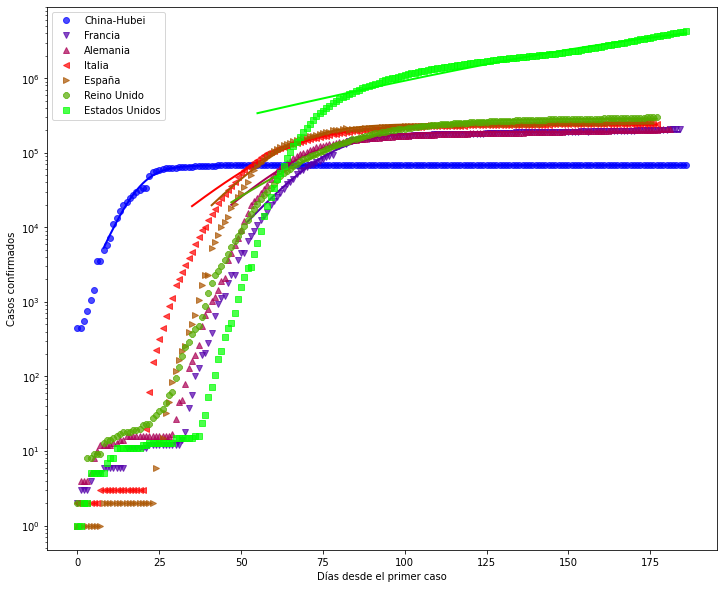

In [6]:
plot_fit(cases_no_lat, 4500, 'Casos confirmados', p_fin=0.01)

### Países latinoamericanos

--------------------------------------------------------------------------------
Argentina
N_inf: 418813 +/- 15345 (1 sigma)
lambda_0: 0.048 +/- 0.000 (1 sigma)
t_fin(0.01): 188 días desde el primer caso de ajuste (día 104) -> 2020-11-09
--------------------------------------------------------------------------------
No hay convergencia para Brasil
--------------------------------------------------------------------------------
Chile
N_inf: 348494 +/- 1331 (1 sigma)
lambda_0: 0.071 +/- 0.001 (1 sigma)
t_fin(0.01): 130 días desde el primer caso de ajuste (día 75) -> 2020-08-14
--------------------------------------------------------------------------------
Colombia
N_inf: 1012498 +/- 70729 (1 sigma)
lambda_0: 0.043 +/- 0.000 (1 sigma)
t_fin(0.01): 226 días desde el primer caso de ajuste (día 94) -> 2020-12-07
--------------------------------------------------------------------------------
Ecuador
N_inf: 115469 +/- 10967 (1 sigma)
lambda_0: 0.025 +/- 0.002 (1 sigma)
t_fin(0.01): 263 días

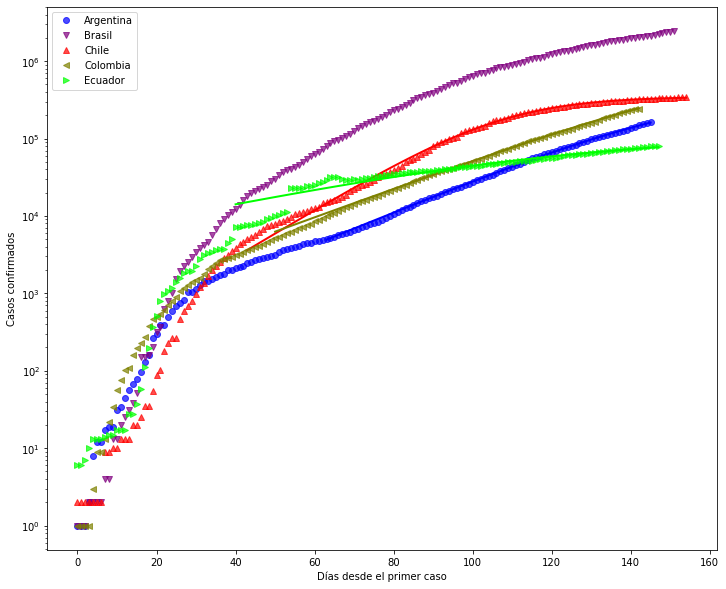

In [7]:
plot_fit(cases_lat, 5000, 'Casos confirmados', logscale=True, p_fin=0.01)

### Países escandinavos

--------------------------------------------------------------------------------
Dinamarca
N_inf: 12687 +/- 60 (1 sigma)
lambda_0: 0.067 +/- 0.002 (1 sigma)
t_fin(0.01): 105 días desde el primer caso de ajuste (día 49) -> 2020-06-24
--------------------------------------------------------------------------------
Finlandia
N_inf: 7238 +/- 16 (1 sigma)
lambda_0: 0.072 +/- 0.001 (1 sigma)
t_fin(0.01): 97 días desde el primer caso de ajuste (día 55) -> 2020-06-22
--------------------------------------------------------------------------------
Islandia
N_inf: 1814 +/- 1 (1 sigma)
lambda_0: 0.170 +/- 0.002 (1 sigma)
t_fin(0.01): 36 días desde el primer caso de ajuste (día 57) -> 2020-04-24
--------------------------------------------------------------------------------
Noruega
N_inf: 8650 +/- 34 (1 sigma)
lambda_0: 0.091 +/- 0.003 (1 sigma)
t_fin(0.01): 72 días desde el primer caso de ajuste (día 48) -> 2020-05-21
------------------------------------------------------------------------------

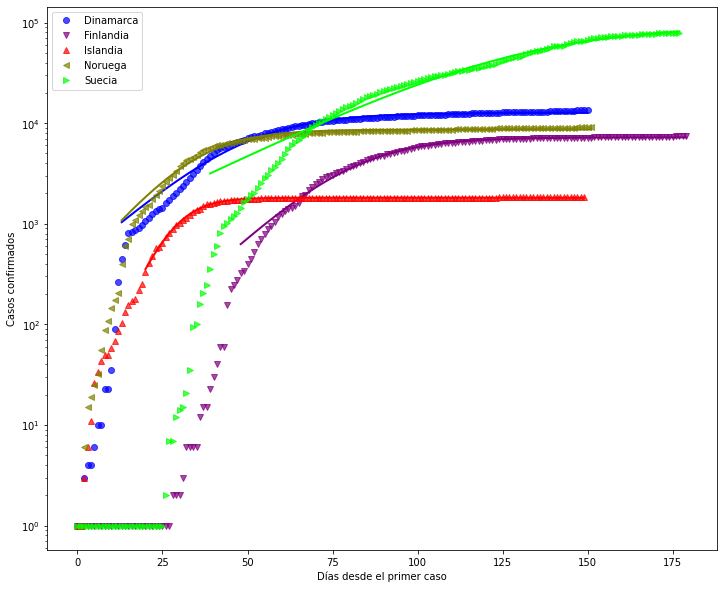

In [8]:
plot_fit(cases_scand, 300, 'Casos confirmados', p_fin=0.01)

## Número de muertes registradas

El número de personas fallecidas por el COVID-19 se registra con mayor precisión, por lo que sus números son mas confiables que el de los casos confirmados. A continuación hacemos el ajuste del modelo logístico sobre estos datos.

### Países no latinoamericanos

--------------------------------------------------------------------------------
China-Hubei
N_inf: 4574 +/- 41 (1 sigma)
lambda_0: 0.042 +/- 0.002 (1 sigma)
t_fin(0.01): 137 días desde el primer caso de ajuste (día 12) -> 2020-06-19
--------------------------------------------------------------------------------
Francia
N_inf: 29260 +/- 104 (1 sigma)
lambda_0: 0.112 +/- 0.003 (1 sigma)
t_fin(0.01): 66 días desde el primer caso de ajuste (día 58) -> 2020-05-25
--------------------------------------------------------------------------------
Alemania
N_inf: 8887 +/- 27 (1 sigma)
lambda_0: 0.094 +/- 0.002 (1 sigma)
t_fin(0.01): 72 días desde el primer caso de ajuste (día 66) -> 2020-06-08
--------------------------------------------------------------------------------
Italia
N_inf: 34360 +/- 123 (1 sigma)
lambda_0: 0.080 +/- 0.002 (1 sigma)
t_fin(0.01): 90 días desde el primer caso de ajuste (día 47) -> 2020-06-07
---------------------------------------------------------------------------

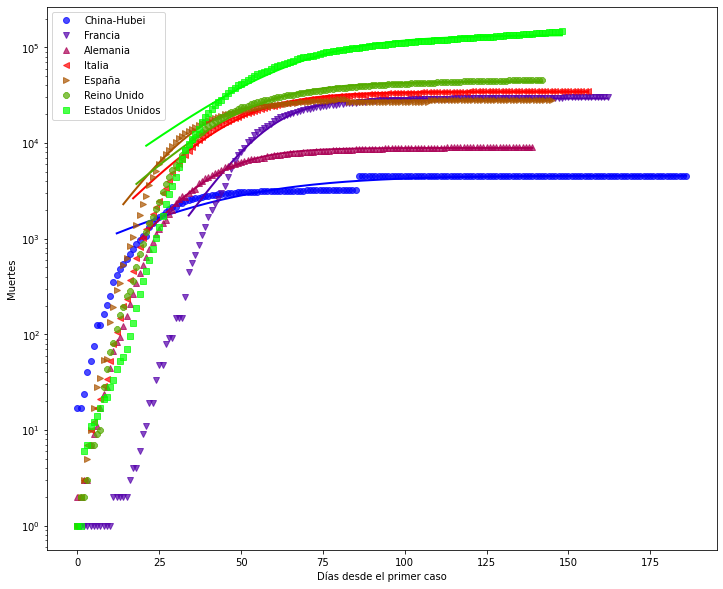

In [9]:
plot_fit(deadths_no_lat, 400, 'Muertes', logscale=True, p_fin=0.01)

### Países latinoamericanos

--------------------------------------------------------------------------------
Argentina
N_inf: 239626591047 +/- 92999762937160976 (1 sigma)
lambda_0: 0.030 +/- 0.000 (1 sigma)
t_fin(0.01): 880 días desde el primer caso de ajuste (día 65) -> 2022-08-24
--------------------------------------------------------------------------------
Brasil
N_inf: 95233 +/- 1323 (1 sigma)
lambda_0: 0.051 +/- 0.001 (1 sigma)
t_fin(0.01): 182 días desde el primer caso de ajuste (día 58) -> 2020-09-18
--------------------------------------------------------------------------------
Chile
N_inf: 9740 +/- 177 (1 sigma)
lambda_0: 0.072 +/- 0.002 (1 sigma)
t_fin(0.01): 151 días desde el primer caso de ajuste (día 69) -> 2020-08-29
--------------------------------------------------------------------------------
Colombia
N_inf: 29038 +/- 1609 (1 sigma)
lambda_0: 0.045 +/- 0.000 (1 sigma)
t_fin(0.01): 243 días desde el primer caso de ajuste (día 67) -> 2020-11-27
--------------------------------------------------

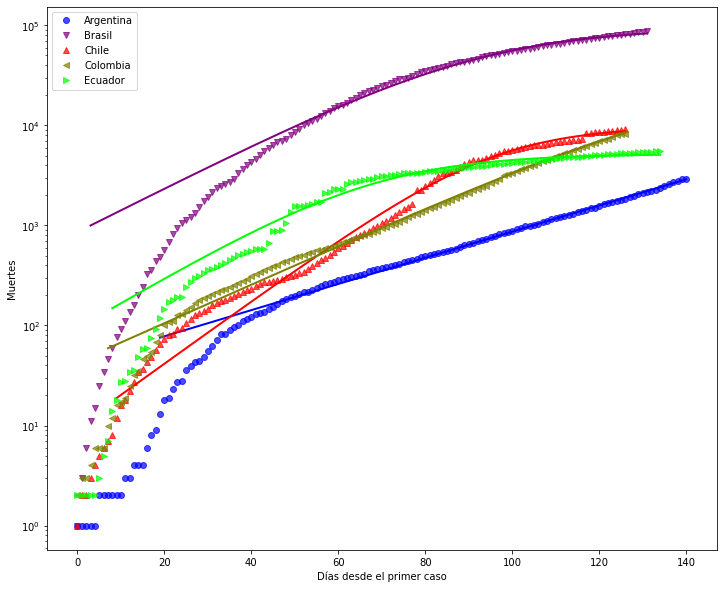

In [10]:
plot_fit(deadths_lat, 10, 'Muertes', logscale=True, p_fin=0.01)

### Países escandinavos

--------------------------------------------------------------------------------
Dinamarca
N_inf: 598 +/- 2 (1 sigma)
lambda_0: 0.089 +/- 0.002 (1 sigma)
t_fin(0.01): 78 días desde el primer caso de ajuste (día 59) -> 2020-06-07
--------------------------------------------------------------------------------
No hay convergencia para Finlandia
--------------------------------------------------------------------------------
No se pueden calcular las varianzas para Islandia
--------------------------------------------------------------------------------
Noruega
N_inf: 243 +/- 0 (1 sigma)
lambda_0: 0.116 +/- 0.003 (1 sigma)
t_fin(0.01): 61 días desde el primer caso de ajuste (día 61) -> 2020-05-23
--------------------------------------------------------------------------------
No hay convergencia para Suecia


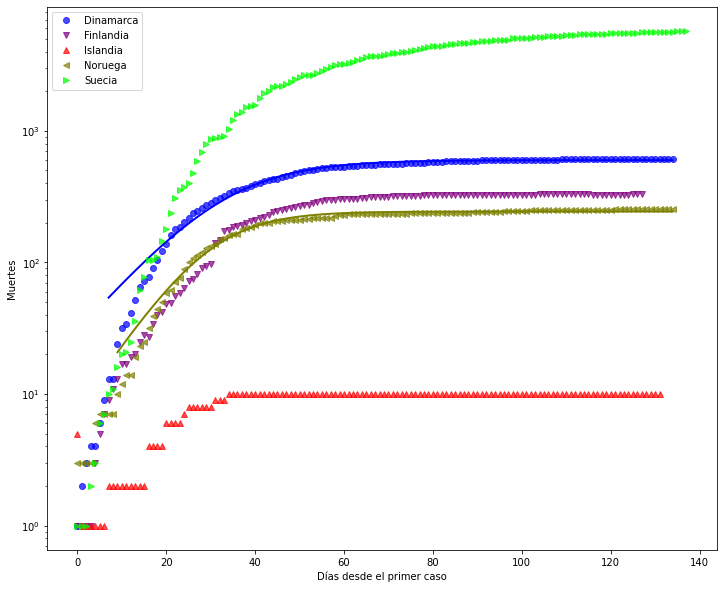

In [11]:
plot_fit(deadths_scand, 10, 'Muertes', logscale=True, p_fin=0.01)

## Registro diario de predicciones para países latinoamericanos

Aquí hago una tabla ragistrando las predicciones diarias del modelo para ver cómo va cambiando a medida que se introducen más datos. 

**Nota**: cuando el proceso de ajuste no converge a una solución, o la desviación estándar es de mayor magnitud que el valor ajustado, se denota NC.

### Argentina

| Fecha | Casos totales | Desv. Estándar | Muertes totales | Desv. Estándar | Fecha de finalización - casos| Fecha de finalización - muertes|
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
|30.3.2020 | 1165 | 143 | NC | NC | 2020-04-13 | NC |
|31.3.2020 | 1154 | 94 | 48 | 22 | 2020-04-12 | 2020-04-15 |
| 1.4.2020 | 1846 | 381 | 49 | 13 | 2020-04-19 | 2020-04-15 |
| 2.4.2020 | 1633 | 199 | 42 | 6 | 2020-04-18 | 2020-04-14 |
| 3.4.2020 | 1569 | 129 | 78 | 24 | 2020-04-17 | 2020-04-23 |
| 4.4.2020 | 1667 | 16 | 76 | 14 | 2020-04-18 | 2020-04-23 |
| 6.4.2020 | 1915 | 118 | 62 | 4 | 2020-04-21 | 2020-04-20 |
| 7.4.2020 | 1943 | 95 | 61 | 3 | 2020-04-21 | 2020-04-19 |
| 8.4.2020 | 1965 | 78 | 70 | 4 | 2020-04-21 | 2020-04-22 |
| 9.4.2020 | 2005 | 67 | 86 | 7 | 2020-04-22 | 2020-04-26 |
| 10.4.2020 | 2049 | 59 | 113 | 19 | 2020-04-22 | 2020-05-02 |
| 11.4.2020 | 2188 | 74 | 168 | 45 | 2020-04-24 | 2020-05-09 |
| 12.4.2020 | 2230 | 65 | 147 | 17 | 2020-04-25 | 2020-05-07 |
| 13.4.2020 | 2347 | 73 | 147 | 14 | 2020-04-27 | 2020-05-06 |
| 14.4.2020 | 2435 | 74 | 161 | 20 | 2020-04-28 | 2020-05-09 |
| 15.4.2020 | 2506 | 71 | 157 | 14 | 2020-04-29 | 2020-05-09 |
| 16.4.2020 | 2634 | 81 | 156 | 9 | 2020-05-01 | 2020-05-08 |
| 17.4.2020 | 2781 | 94 | 157 | 7 | 2020-05-03 | 2020-05-08 |
| 18.4.2020 | 2918 | 102 | 164 | 8 | 2020-05-05 | 2020-05-09 |
| 19.4.2020 | 3040 | 106 | 174 | 8 | 2020-05-06 | 2020-05-12 |
| 20.4.2020 | 3143 | 107 | 168 | 5 | 2020-05-08 | 2020-05-10 |
| 21.4.2020 | 3246 | 107 | 167 | 4 | 2020-05-09 | 2020-05-10 |
| 22.4.2020 | 3320 | 98 | 173 | 4 | 2020-05-10 | 2020-05-11 |
| 23.4.2020 | 3423 | 99 | 178 | 4 |  2020-05-11 | 2020-05-12 |
| 24.4.2020 | 3672 | 136 | 189 | 5 | 2020-05-15 | 2020-05-14 |
| 25.4.2020 | 3935 | 169 | 204 | 6 | 2020-05-18 | 2020-05-17 |
| 26.4.2020 | 4233 | 207 | 219 | 8 | 2020-05-22 | 2020-05-20 |
| 27.4.2020 | 4506 | 235 | 236 | 11 | 2020-05-25 | 2020-05-23 |
| 28.4.2020 | 4745 | 252 | 245 | 10 | 2020-05-27 | 2020-05-24 |
| 29.4.2020 | 4959 | 262 | 256 | 11 | 2020-05-30 | 2020-05-26 |
| 30.4.2020 | 5183 | 272 | 266 | 11 | 2020-06-01 | 2020-05-27 |
| 1.5.2020 | 5399 | 280 | 271 | 10 | 2020-06-03 | 2020-05-28 |
| 2.5.2020 | 5570 | 278 | 275 | 9 | 2020-06-05 | 2020-05-29 |
| 3.5.2020 | 5745 | 277 | 281 | 8 | 2020-06-06 | 2020-05-30 |
| 4.5.2020 | 5792 | 247 | 294 | 9 | 2020-06-06 | 2020-06-01 |
| 5.5.2020 | 5905 | 238 | 327 | 12 | 2020-06-07 | 2020-06-08 |
| 6.5.2020 | 6434 | 281 | 341 | 13 | 2020-06-14 | 2020-06-10 |
| 7.5.2020 | 6584 | 274 | 351 | 12 |  2020-06-16 | 2020-06-12 |
| 8.5.2020 | 6754 | 272 | 361 | 12 | 2020-06-17 | 2020-06-13 |
| 9.5.2020 | 7007 | 286 | 386 | 14 | 2020-06-20 | 2020-06-18 |
| 10.5.2020 | 7263 | 299 | 396 | 14 | 2020-06-22 | 2020-06-19 |
| 11.5.2020 | 7608 | 330 | 411 | 14 | 2020-06-25 | 2020-06-22 |
| 12.5.2020 | 8023 | 375 | 416 | 13 | 2020-06-28 | 2020-06-23 |
| 13.5.2020 | 8554 | 443 | 406 | 11 | 2020-07-02 | 2020-06-20 |
| 14.5.2020 | 9795 | 616 | 383 | 9 | 2020-07-13 | 2020-06-14 |
| 15.5.2020 | 10019 | 671 | 399 | 10 | 2020-07-12 | 2020-06-17 |
| 16.5.2020 | 11585 | 948 | 429 | 13 | 2020-07-23 | 2020-06-22 |
| 17.5.2020 | 12984 | 1247 | 439 | 13 | 2020-07-30 | 2020-06-24 |
| 18.5.2020 | 14466 | 1568 | 450 | 13 | 2020-08-05 | 2020-06-26 |
| 19.5.2020 | 15515 | 1793 | 458 | 13 | 2020-08-08 | 2020-06-27 |
| 20.5.2020 | 17084 | 2197 | 491 | 14 | 2020-08-13 | 2020-07-03 |
| 21.5.2020 | 20128 | 3139 | 503 | 14 | 2020-08-22 | 2020-07-04 |
| 22.5.2020 | 26097 | 5681 | 506 | 14 | 2020-09-04 | 2020-07-04 |
| 23.5.2020 | 40712 | 15362 | 521 | 16 | 2020-09-23 | 2020-07-06 |
| 24.5.2020 | 101045 | 104532 | 550 | 18 | 2020-10-26 | 2020-07-10 |
| 25.5.2020 | 70520 | 46082 | 567 | 18 | 2020-10-07 | 2020-07-13 |
| 26.5.2020 | NC | NC | 573 | 19 | NC | 2020-07-12 |
| 27.5.2020 | NC | NC | 582 | 20 | NC | 2020-07-13 |
| 28.5.2020 | NC | NC | 590 | 19 | NC | 2020-07-13 |
| 29.5.2020 | NC | NC | 614 | 21 | NC | 2020-07-16 |
| 30.5.2020 | NC | NC | 678 | 27 | NC | 2020-07-26 |
| 31.5.2020 | NC | NC | 651 | 22 | NC | 2020-07-20 |
| 01.6.2020 | NC | NC | 712 | 27 | NC | 2020-07-29 |
| 02.6.2020 | NC | NC | 720 | 27 | NC | 2020-07-30 |
| 03.6.2020 | NC | NC | 740 | 28 | NC | 2020-08-01 |
| 04.6.2020 | NC | NC | 743 | 27 | NC | 2020-07-31 |
| 05.6.2020 | NC | NC | 786 | 30 | NC | 2020-08-05 |
| 06.6.2020 | NC | NC | 825 | 35 | NC | 2020-08-09 |
| 07.6.2020 | NC | NC | 865 | 38 | NC | 2020-08-13 |
| 08.6.2020 | NC | NC | 905 | 42 | NC | 2020-08-16 |
| 09.6.2020 | NC | NC | 990 | 52 | NC | 2020-08-24 |
| 10.6.2020 | NC | NC | 1058 | 62 | NC | 2020-08-30 |
| 11.6.2020 | NC | NC | 1178 | 78 | NC | 2020-09-08 |
| 12.6.2020 | NC | NC | 1568 | 146 | NC | 2020-10-04 |
| 13.6.2020 | NC | NC | 1311 | 100 | NC | 2020-09-15 |
| 14.6.2020 | NC | NC | 1513 | 137 | NC | 2020-09-26 |
| 15.6.2020 | NC | NC | 1883 | 215 | NC | 2020-10-15 |
| 17.6.2020 | NC | NC | 3954 | 922 | NC | 2020-12-07 |
| 18.6.2020 | NC | NC | 2808 | 439 | NC | 2020-11-12 |
| 19.6.2020 | NC | NC | 3231 | 577 | NC | 2020-11-20 |
| 20.6.2020 | NC | NC | 3757 | 770 | NC | 2020-11-29 |
| 21.6.2020 | NC | NC | 4025 | 834 | NC | 2020-12-03 |
| 22.6.2020 | 613781 | 292776 | 4111 | 810 | 2020-11-20 | 2020-12-04 |
| 23.6.2020 | 633848 | 279596 | 5332 | 1243 | 2020-11-21 | 2020-12-20 |
| 24.6.2020 | 1224130 | 1010724 | 5653 | 1310 | 2020-12-08 | 2020-12-23 |
| 25.6.2020 | 1159916 | 794496 | 6219 | 1502 | 2020-12-06 | 2020-12-28 |
| 26.6.2020 | 2980604 | 4959663 | 6865 | 1733 | 2020-12-29 | 2021-01-02 |
| 27.6.2020 | NC | NC | 7551 | 1981 | NC | 2021-01-07 |
| 29.6.2020 | NC | NC | 87903 | 204591 | NC | 2021-04-26 |
| 30.6.2020 | NC | NC | 10811 | 3131 | NC | 2021-01-26 |
| 01.7.2020 | NC | NC | 10429 | 2693 | NC | 2021-01-25 |
| 02.7.2020 | NC | NC | 10697 | 2638 | NC | 2021-01-26 |
| 03.7.2020 | 2007122 | 1308992 | 10663 | 2431 | 2020-12-21 | 2021-01-26 |
| 04.7.2020 | 1189706 | 426647 | 11584 | 2704 | 2020-12-07 | 2021-01-30 |
| 06.7.2020 | 615314 | 102645 | 12467 | 2745 | 2020-11-19 | 2021-02-02 |
| 07.7.2020 | 496534 | 63906 | 15157 | 3959 | 2020-11-12 | 2021-02-11 |
| 08.7.2020 | 430634 | 45155 | 21199 | 7777 | 2020-11-08 | 2021-02-26 |
| 10.7.2020 | 390031 | 30804 | 34579 | 19025 | 2020-11-04 | 2021-03-18 |
| 11.7.2020 | 380519 | 26658 | 39260 | 22969 | 2020-11-03 | 2021-03-23 |
| 13.7.2020 | 355662 | 19539 | 27603 | 9870 | 2020-11-01 | 2021-03-09 |
| 14.7.2020 | 335197 | 16055 | 71543 | 55714 | 2020-10-29 | 2021-04-18 |
| 16.7.2020 | 324102 | 12571 | 96301 | 89360 | 2020-10-28 | 2021-04-29 |
| 20.7.2020 | 310488 | 7166 | 37620 | 12163 | 2020-10-25 | 2021-03-21 |
| 22.7.2020 | 322472 | 7037 | 131459 | 150532 | 2020-10-27 | 2021-05-08 |
| 24.7.2020 | 369869 | 11112 | 25677 | 8956 | 2020-11-03 | 2021-02-25 |
| 27.7.2020 | 418813 | 15345 | NC | NC | 2020-11-09 | NC |

### Brasil

| Fecha | Casos totales | Desv. Estándar | Muertes totales | Desv. Estándar | Fecha de finalización - casos| Fecha de finalización - muertes|
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
|31.3.2020 | 5526 | 178 | 254 | 22 | 2020-04-09 | 2020-04-12 |
|1.4.2020 | 7322 | 650 | 421 | 90 | 2020-04-14 | 2020-04-17 |
|2.4.2020 | 11675 | 223 | 551 | 116 | 2020-04-21 | 2020-04-19 |
| 3.4.2020 | 20827 | 7241 | 26120 | 395617 | 2020-04-29 | 2020-05-13 |
| 4.4.2020 | 26334 | 8901 | 1544 | 886 | 2020-05-01 | 2020-04-28 |
| 5.4.2020 | 31033 | 9301 | 1837 | 795 | 2020-05-03 | 2020-04-29 |
| 6.4.2020 | 25592 | 4454 | 1062 | 165 | 2020-05-01 | 2020-04-24 |
| 7.4.2020 | 23358 | 2682 | 1075 | 115 | 2020-04-30 | 2020-04-24 |
| 8.4.2020 | 26723 | 2914 | 1509 | 230 | 2020-05-02 | 2020-04-28 |
| 9.4.2020 | 34583 | 4675 | 2336 | 514 | 2020-05-06 | 2020-05-03 |
| 10.4.2020 | 42517 | 6091 | 3096 | 711 | 2020-05-09 | 2020-05-06 |
| 11.4.2020 | 43763 | 4941 | 2685 | 363 | 2020-05-09 | 2020-05-04 |
| 12.4.2020 | 39541 | 3084 | 2075 | 166 | 2020-05-08 | 2020-05-01 |
| 13.4.2020 | 37486 | 2142 | 1923 | 106 | 2020-05-07 | 2020-04-30 |
| 14.4.2020 | 35930 | 1550 | 1901 | 78 | 2020-05-06 | 2020-04-30 |
| 15.4.2020 | 36306 | 1269 | 2178 | 116 | 2020-05-06 | 2020-05-02 |
| 16.4.2020 | 40235 | 1699 | 2649 | 199 | 2020-05-08 | 2020-05-06 |
| 17.4.2020 | 44088 | 2000 | 3177 | 281 | 2020-05-11 | 2020-05-09 |
| 18.4.2020 | 50884 | 2968 | 3816 | 387 | 2020-05-14 | 2020-05-13 |
| 19.4.2020 | 59028 | 4114 | 4401 | 455 | 2020-05-18 | 2020-05-15 |
| 20.4.2020 | 63648 | 4202 | 4258 | 321 | 2020-05-20 | 2020-05-15 |
| 21.4.2020 | 65854 | 3788 | 4058 | 224 | 2020-05-20 | 2020-05-14 |
| 22.4.2020 | 67400 | 3262 | 3984 | 170 | 2020-05-21 | 2020-05-13 |
| 23.4.2020 | 69584 | 2983 | 3994 | 138 | 2020-05-22 | 2020-05-13 |
| 24.4.2020 | 75994 | 3588 | 4531 | 220 | 2020-05-24 | 2020-05-17 |
| 25.4.2020 | 84694 | 4647 | 5443 | 394 | 2020-05-27 | 2020-05-21 |
| 26.4.2020 | 99236 | 7083 | 6672 | 643 | 2020-06-01 | 2020-05-26 |
| 27.4.2020 | 112796 | 8899 | 7497 | 738 | 2020-06-04 | 2020-05-29 |
| 28.4.2020 | 126387 | 10470 | 8222 | 780 | 2020-06-07 | 2020-05-31 |
| 29.4.2020 | 146358 | 13637 | 9618 | 1014 | 2020-06-11 | 2020-06-04 |
| 30.4.2020 | 175813 | 19506 | 11204 | 1277 | 2020-06-16 | 2020-06-07 |
| 1.5.2020 | 224159 | 2078 | 13215 | 1648 | 2020-06-22 | 2020-06-11 |
| 2.5.2020 | 257129 | 37852 | 14586 | 1747 | 2020-06-25 | 2020-06-13 |
| 3.5.2020 | 266966 | 34879 | 14805 | 1484 | 2020-06-26 | 2020-06-14 |
| 4.5.2020 | 257989 | 26495 | 14263 | 1148 | 2020-06-25 | 2020-06-13 |
| 5.5.2020 | 261136 | 23167 | 13695 | 898 | 2020-06-25 | 2020-06-12 |
| 6.5.2020 | 271524 | 22733 | 14028 | 809 | 2020-06-26 | 2020-06-12 |
| 7.5.2020 | 310050 | 28406 | 15045 | 857 | 2020-06-30 | 2020-06-14 |
| 8.5.2020 | 356391 | 35650 | 16328 | 952 | 2020-07-03 | 2020-06-17 |
| 9.5.2020 | 428322 | 50371 | 18764 | 1329 | 2020-07-08 | 2020-06-21 |
| 10.5.2020 | 489268 | 60071 | 21112 | 1629 | 2020-07-11 | 2020-06-24 |
| 11.5.2020 | 490952 | 51815 | 22314 | 1614 | 2020-07-11 | 2020-06-26 | 
| 12.5.2020 | 464303 | 39644 | 22783 | 1449 | 2020-07-10 | 2020-06-26 |
| 13.5.2020 | 444910 | 31254 | 23970 | 1430 | 2020-07-09 | 2020-06-28 |
| 14.5.2020 | 456698 | 28995 | 25240 | 1401 | 2020-07-09 | 2020-06-29 |
| 15.5.2020 | 477021 | 28122 | 26757 | 1436 | 2020-07-10 | 2020-07-01 |
| 16.5.2020 | 546045 | 38057 | 29183 | 1660 | 2020-07-14 | 2020-07-03 |
| 17.5.2020 | 612494 | 46194 | 30697 | 1660 | 2020-07-18 | 2020-07-05 |
| 18.5.2020 | 617838 | 40861 | 30594 | 1424 | 2020-07-18 | 2020-07-05 |
| 19.5.2020 | 633782 | 37598 | 30590 | 1229 | 2020-07-19 | 2020-07-05 |
| 20.5.2020 | 673418 | 38808 | 32053 | 1258 | 2020-07-20 | 2020-07-06 |
| 21.5.2020 | 749652 | 47328 | 33350 | 1253 | 2020-07-23 | 2020-07-08 |
| 22.5.2020 | 841721 | 58514 | 35425 | 1382 | 2020-07-27 | 2020-07-10 |
| 23.5.2020 | NC | NC | 37590 | 1504 | NC | 2020-07-12 |
| 24.5.2020 | 1050930 | 83168 | 39634 | 1588 | 2020-08-02 | 2020-07-14 |
| 25.5.2020 | NC | NC | 40312 | 1463 | NC | 2020-07-15 |
| 26.5.2020 | NC | NC | 40528 | 1299 | NC | 2020-07-15 |
| 27.5.2020 | 1008180 | 53270 | 41167 | 1200 | 2020-08-01 | 2020-07-15 |
| 28.5.2020 | NC | NC | NC | NC | NC | NC |
| 29.5.2020 | NC | NC | 43418 | 1143 | NC | 2020-07-17 |
| 30.5.2020 | NC | NC | NC | NC | NC | NC |
| 31.5.2020 | NC | NC | 45965 | 1130 | NC | 2020-07-20 |
| 01.6.2020 | NC | NC | 46079 | 1023 | NC | 2020-07-20 |
| 02.6.2020 | 1283480 | 58676 | NC | NC | 2020-08-09 | NC |
| 03.6.2020 | 1294537 | 52504 | 46057 | 826 | 2020-08-09 | 2020-07-20 |
| 04.6.2020 | 1344433 | 52718 | 46991 | 817 | 2020-08-10 | 2020-07-21 |
| 05.6.2020 | 1395161 | 52038 | 48515 | 891 | 2020-08-12 | 2020-07-23 |
| 06.6.2020 | NC | NC | 48600 | 807 | NC | 2020-07-23 |
| 07.6.2020 | NC | NC | 50906 | 924 | NC | 2020-07-25 |
| 08.6.2020 | NC | NC | 51302 | 859 | NC | 2020-07-25 |
| 09.6.2020 | 1482790 | 41572 | 51471 | 791 | 2020-08-14 | 2020-07-26 |
| 10.6.2020 | NC | NC | 52016 | 752 | NC | 2020-07-26 |
| 11.6.2020 | 1497852 | 35166 | 52880 | 750 | 2020-08-14 | 2020-07-27 |
| 12.6.2020 | 1523899 | 33571 | 53987 | 777 | 2020-08-15 | 2020-07-28 |
| 13.6.2020 | 1537899 | 31001 | NC | NC | 2020-08-15 | NC |
| 14.6.2020 | 1534549 | 27552 | 55570 | 760 | 2020-08-15 | 2020-07-30 |
| 15.6.2020 | NC | NC | 56080 | 727 | NC | 2020-07-31 |
| 17.6.2020 | NC | NC | 57021 | 665 | NC | 2020-08-01 |
| 18.6.2020 | 1500841 | 18835 | 57729 | 669 | 2020-08-14 | 2020-08-02 |
| 19.6.2020 | NC | NC | 58675 | 696 | NC | 2020-08-03 |
| 20.6.2020 | 1555170 | 20846 | 59725 | 734 | 2020-08-16 | 2020-08-04 |
| 21.6.2020 | 1557467 | 19061 | NC | NC | 2020-08-16 | NC |
| 22.6.2020 | 1596534 | 20967 | NC | NC | 2020-08-18 | NC |
| 23.6.2020 | 1651550 | 23290 | 62200 | 753 | 2020-08-19 | 2020-08-07 |
| 24.6.2020 | 1680508 | 23447 | 63050 | 764 | 2020-08-20 | 2020-08-08 |
| 25.6.2020 | 1724954 | 25646 | 63994 | 786 | 2020-08-22 | 2020-08-09 |
| 26.6.2020 | NC | NC | 64995 | 814 | NC | 2020-08-10 |
| 27.6.2020 | 1838525 | 32814 | 65972 | 837 | 2020-08-26 | 2020-08-11 |
| 29.6.2020 | 1963265 | 39820 | 67871 | 871 | 2020-08-30 | 2020-08-14 |
| 30.6.2020 | 2000139 | 39057 | NC | NC | 2020-08-31 | NC |
| 01.7.2020 | NC | NC | 69289 | 858 | NC | 2020-08-16 |
| 02.7.2020 | 2087900 | 40155 | 70132 | 866 | 2020-09-03 | 2020-08-17 |
| 03.7.2020 | NC | NC | NC | NC | NC | NC |
| 04.7.2020 | NC | NC | NC | NC | NC | NC |
| 06.7.2020 | NC | NC | NC | NC | NC | NC |
| 07.7.2020 | NC | NC | 74875 | 958 | NC | 2020-08-23 |
| 08.7.2020 | NC | NC | NC | NC | NC | NC |
| 10.7.2020 | NC | NC | NC | NC | NC | NC |
| 11.7.2020 | NC | NC | 78802 | 1040 | NC | 2020-08-28 |
| 13.7.2020 | 2591278 | 45369 | NC | NC | 2020-09-17 | NC |
| 14.7.2020 | 2610717 | 43537 | 81783 | 1095 | 2020-09-18 | 2020-08-31 |
| 16.7.2020 | 2661985 | 40979 | NC | NC | 2020-09-19 | NC |
| 20.7.2020 | 2771700 | 37980 | NC | NC | 2020-09-23 | NC |
| 22.7.2020 | NC | NC | 89921 | 1241 | NC | 2020-09-11 |
| 24.7.2020 | NC | NC | 91812 | 1234 | NC | 2020-09-13 |
| 27.7.2020 | NC | NC | 95233 | 1323 | NC | 2020-09-18 |

### Chile

| Fecha | Casos totales | Desv. Estándar | Muertes totales | Desv. Estándar | Fecha de finalización - casos| Fecha de finalización - muertes|
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
|31.3.2020 | 4364 | 359 | 12 | $<$1 | 2020-04-12 | 2020-04-11 |
|1.4.2020 | 4491 | 266 | NC | NC | 2020-04-17 | NC |
|2.4.2020 | 4627 | 204 | NC | NC | 2020-04-17 | NC |
| 3.4.2020 | 5039 | 214 | 517 | 4987 | 2020-04-19 | 2020-05-06 |
| 4.4.2020 | 5392 | 208 | 84 | 58 | 2020-04-20 | 2020-04-25 |
| 5.4.2020 | 5962 | 254 | 61 | 29 | 2020-04-22 | 2020-04-21 |
| 6.4.2020 | 6272 | 233 | 191 | 136 | 2020-04-23 | 2020-05-01 |
| 7.4.2020 | 6545 | 211 | 84 | 18 | 2020-04-23 | 2020-04-25 |
| 8.4.2020 | 6722 | 181 | 80 | 10 | 2020-04-24 | 2020-04-24 |
| 9.4.2020 | 7094 | 194 | 78 | 6 | 2020-04-25 | 2020-04-24 |
| 10.4.2020 | 7554 | 233 | 96 | 11 | 2020-04-27 | 2020-04-27 |
| 11.4.2020 | 8231 | 298 | 117 | 14 | 2020-04-29 | 2020-04-29 |
| 12.4.2020 | 8860 | 342 | 128 | 10 | 2020-05-01 | 2020-05-01 |
| 13.4.2020 | 9203 | 322 | 132 | 8 | 2020-05-02 | 2020-05-01 |
| 14.4.2020 | 9428 | 289 | 118 | 7 | 2020-05-02 | 2020-04-29 |
| 15.4.2020 | 9699 | 269 | 123 | 6 | 2020-05-03 | 2020-04-30 |
| 16.4.2020 | 9961 | 253 | 120 | 3 | 2020-05-04 | 2020-04-29 |
| 17.4.2020 | 10403 | 272 | 127 | 4 | 2020-05-06 | 2020-05-01 |
| 18.4.2020 | 10875 | 295 | 142 | 6 | 2020-05-07 | 2020-05-03 |
| 19.4.2020 | 11399 | 324 | 164 | 11 | 2020-05-09 | 2020-05-07 |
| 20.4.2020 | 11839 | 334 | 171 | 9 | 2020-05-10 | 2020-05-08 |
| 21.4.2020 | 12274 | 341 | 177 | 8 | 2020-05-11 | 2020-05-09 |
| 22.4.2020 | 12608 | 331 | 184 | 7 | 2020-05-12 | 2020-05-10 |
| 23.4.2020 | 13010 | 335 | 198 | 9 | 2020-05-14 | 2020-05-12 |
| 24.4.2020 | 13507 | 357 | 208 | 8 | 2020-05-15 | 2020-05-13 |
| 25.4.2020 | 14080 | 390 | 215 | 8 | 2020-05-17 | 2020-05-14 |
| 26.4.2020 | 14683 | 426 | 220 | 7 | 2020-05-19 | 2020-05-15 |
| 27.4.2020 | 15283 | 458 | 228 | 7 | 2020-05-21 | 2020-05-16 |
| 28.4.2020 | 15884 | 486 | 235 | 7 | 2020-05-23 | 2020-05-18 |
| 29.4.2020 | 16535 | 521 | 243 | 7 | 2020-05-25 | 2020-05-19 |
| 30.4.2020 | 17199 | 554 | 251 | 7 | 2020-05-26 | 2020-05-20 |
| 1.5.2020 | 18370 | 695 | 262 | 7 | 2020-05-30 | 2020-05-22 |
| 2.5.2020 | 19928 | 913 | 271 | 7 | 2020-06-03 | 2020-05-23 |
| 3.5.2020 | 22443 | 1376 | 281 | 8 | 2020-06-09 | 2020-05-24 |
| 4.5.2020 | 25544 | 1969 | 298 | 10 | 2020-06-14 | 2020-05-27 |
| 5.5.2020 | 29562 | 2832 | 327 | 12 | 2020-06-21 | 2020-06-01 |
| 6.5.2020 | 37980 | 5483 | 341 | 12 | 2020-07-03 | 2020-06-04 |
| 7.5.2020 | 45580 | 7953 | 347 | 11 | 2020-07-10 | 2020-06-05 |
| 8.5.2020 | 56868 | 12460 | 349 | 10 | 2020-07-19 | 2020-06-05 |
| 9.5.2020 | 71595 | 19341 | 364 | 9 | 2020-07-27 | 2020-06-08 |
| 10.5.2020 | 87114 | 27028 | 370 | 9 | 2020-08-02 | 2020-06-09 |
| 11.5.2020 | 108740 | 39614 | 379 | 8 | 2020-08-09 | 2020-06-11 | 
| 12.5.2020 | 123976 | 46826 | 387 | 8 | 2020-08-13 | 2020-06-12 |
| 13.5.2020 | 141842 | 55617 | 390 | 9 | 2020-08-17 | 2020-06-12 |
| 14.5.2020 | 331602 | 298755 | 379 | 9 | 2020-09-10 | 2020-06-08 |
| 15.5.2020 | 420416 | 451378 | 397 | 11 | 2020-09-14 | 2020-06-11 |
| 16.5.2020 | NC | NC | 437 | 16 | NC | 2020-06-17 |
| 17.5.2020 | NC | NC | 482 | 25 | NC | 2020-06-23 |
| 18.5.2020 | NC | NC | 550 | 40 | NC | 2020-07-01 |
| 19.5.2020 | NC | NC | 630 | 59 | NC | 2020-07-08 |
| 20.5.2020 | NC | NC | 1017 | 226 | NC | 2020-08-06 |
| 21.5.2020 | NC | NC | 1629 | 673 | NC | 2020-08-26 |
| 22.5.2020 | NC | NC | 2381 | 1475 | NC | 2020-09-07 |
| 23.5.2020 | NC | NC | 18087 | 94290 | NC | 2020-11-01 |
| 24.5.2020 | NC | NC | NC | NC | NC | NC |
| 25.5.2020 | NC | NC | NC | NC | NC | NC |
| 26.5.2020 | NC | NC | NC | NC | NC | NC |
| 27.5.2020 | NC | NC | NC | NC | NC | NC |
| 28.5.2020 | NC | NC | NC | NC | NC | NC |
| 29.5.2020 | NC | NC | NC | NC | NC | NC |
| 30.5.2020 | NC | NC | NC | NC | NC | NC |
| 31.5.2020 | NC | NC | NC | NC | NC | NC |
| 01.6.2020 | NC | NC | NC | NC | NC | NC |
| 02.6.2020 | 3879344 | 5972494 | NC | NC | 2020-10-18 | NC |
| 03.6.2020 | 1155955 | 484863 | NC | NC | 2020-09-24 | NC |
| 04.6.2020 | 832557 | 241194 | NC | NC | 2020-09-17 | NC |
| 05.6.2020 | 578958 | 99777 | NC | NC | 2020-09-07 | NC |
| 06.6.2020 | 474583 | 60992 | NC | NC | 2020-09-01 | NC |
| 07.6.2020 | 419959 | 42938 | NC | NC | 2020-08-29 | NC |
| 08.6.2020 | 397483 | 34170 | NC | NC | 2020-08-27 | NC |
| 09.6.2020 | 374214 | 26589 | NC | NC | 2020-08-25 | NC |
| 10.6.2020 | 351376 | 21500 | NC | NC | 2020-08-23 | NC |
| 11.6.2020 | 338042 | 17929 | NC | NC | 2020-08-21 | NC |
| 12.6.2020 | 330654 | 15610 | NC | NC | 2020-08-20 | NC |
| 13.6.2020 | 329851 | 13924 | NC | NC | 2020-08-20 | NC |
| 14.6.2020 | 332478 | 12763 | NC | NC | 2020-08-21 | NC |
| 15.6.2020 | 338650 | 12147 | NC | NC | 2020-08-21 | NC |
| 17.6.2020 | 341358 | 10314 | NC | NC | 2020-08-22 | NC |
| 18.6.2020 | NC | NC | NC | NC | NC | NC |
| 19.6.2020 | 562808 | 67803 | NC | NC | 2020-09-12 | NC |
| 20.6.2020 | 666501 | 90364 | 144316 | 554185 | 2020-09-18 | 2020-10-15 |
| 21.6.2020 | NC | NC | 36110 | 29047 | NC | 2020-09-21 |
| 22.6.2020 | 725274 | 97450 | 21863 | 8966 | 2020-09-22 | 2020-09-10 |
| 23.6.2020 | 683717 | 77428 | 14132 | 3242 | 2020-09-19 | 2020-08-29 |
| 24.6.2020 | 627274 | 58229 | 10517 | 1551 | 2020-09-16 | 2020-08-20 |
| 25.6.2020 | 573476 | 44680 | 9267 | 1034 | 2020-09-12 | 2020-08-16 |
| 26.6.2020 | 531523 | 35142 | 8607 | 770 | 2020-09-09 | 2020-08-13 |
| 27.6.2020 | 498498 | 27847 | 8221 | 611 | 2020-09-05 | 2020-08-11 |
| 29.6.2020 | 451658 | 19720 | 8066 | 477 | 2020-08-31 | 2020-08-10 |
| 30.6.2020 | 435228 | 16418 | 8005 | 409 | 2020-08-29 | 2020-08-10 |
| 01.7.2020 | 421179 | 14264 | 7881 | 351 | 2020-08-27 | 2020-08-09 |
| 02.7.2020 | 408826 | 12518 | 7729 | 301 | 2020-08-25 | 2020-08-08 |
| 03.7.2020 | 398093 | 11089 | 7665 | 265 | 2020-08-24 | 2020-08-08 |
| 04.7.2020 | 389590 | 9908 | 7632 | 236 | 2020-08-22 | 2020-08-07 |
| 06.7.2020 | NC | NC | 7634 | 195 | NC | 2020-08-07 |
| 07.7.2020 | 373401 | 7364 | 7624 | 177 | 2020-08-19 | 2020-08-07 |
| 08.7.2020 | 369567 | 6740 | 7596 | 160 | 2020-08-18 | 2020-08-07 |
| 10.7.2020 | NC | NC | 7614 | 136 | NC | 2020-08-07 |
| 11.7.2020 | 361233 | 5297 | 7635 | 126 | 2020-08-17 | 2020-08-07 |
| 13.7.2020 | NC | NC | 7691 | 111 | NC | 2020-08-08 |
| 14.7.2020 | NC | NC | 7700 | 105 | NC | 2020-08-08 |
| 16.7.2020 | NC | NC | 7736 | 92 | NC | 2020-08-08 |
| 20.7.2020 | NC | NC | 8579 | 164 | NC | 2020-08-17 |
| 22.7.2020 | 353921 | 2847 | 8987 | 183 | 2020-08-15 | 2020-08-22 |
| 24.7.2020 | 354651 | 2543 | 9359 | 173 | 2020-08-15 | 2020-08-25 |
| 27.7.2020 | 348494 | 1331 | 9740 | 177 | 2020-08-14 | 2020-08-29 |

### Colombia

| Fecha | Casos totales | Desv. Estándar | Muertes totales | Desv. Estándar | Fecha de finalización - casos| Fecha de finalización - muertes|
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
|31.3.2020 | 1042 | 92 | NC | NC | 2020-04-12 | 2020-07-06 |
|1.4.2020 | 1263 | 132 | NC | NC | 2020-04-15 | NC |
|2.4.2020 | 1744 | 284 | 74 | 134 | 2020-04-21 | 2020-04-25 |
| 3.4.2020 | 1983 | 291 | 36 | 13 | 2020-04-23 | 2020-04-18 |
| 4.4.2020 | 2082 | 240 | 76 | 58 | 2020-04-24 | 2020-04-26 |
| 5.4.2020 | 2260 | 225 | NC | NC | 2020-04-25 | NC |
| 6.4.2020 | 2237 | 163 | 139 | 102 | 2020-04-25 | 2020-05-01 |
| 7.4.2020 | 6545 | 211 | NC | NC | 2020-04-23 | NC |
| 8.4.2020 | 2452 | 143 | 180 | 88 | 2020-04-27 | 2020-05-03 |
| 9.4.2020 | 3086 | 304 | 107 | 20 | 2020-05-02 | 2020-04-27 |
| 10.4.2020 | 3678 | 415 | 178 | 66 | 2020-05-05 | 2020-05-03 |
| 11.4.2020 | 4532 | 610 | 262 | 111 | 2020-05-10 | 2020-05-08 |
| 12.4.2020 | 5407 | 783 | NC | NC | 2020-05-13 | NC |
| 13.4.2020 | 5078 | 534 | 468 | 201 | 2020-05-12 | 2020-05-13 |
| 14.4.2020 | 4608 | 351 | 228 | 43 | 2020-05-10 | 2020-05-05 |
| 15.4.2020 | 4368 | 254 | 216 | 27 | 2020-05-08 | 2020-05-04 |
| 16.4.2020 | 4243 | 195 | 192 | 14 | 2020-05-08 | 2020-05-02 |
| 17.4.2020 | 4189 | 156 | 193 | 10 | 2020-05-07 | 2020-05-02 |
| 18.4.2020 | 4263 | 139 | 195 | 9 | 2020-05-08 | 2020-05-02 |
| 19.4.2020 | 4206 | 114 | 186 | 7 | 2020-05-07 | 2020-05-01 |
| 20.4.2020 | 4391 | 124 | 205 | 9 | 2020-05-09 | 2020-05-04 |
| 21.4.2020 | 4595 | 136 | 221 | 9 | 2020-05-11 | 2020-05-06 |
| 22.4.2020 | 4792 | 144 | 231 | 9 | 2020-05-12 | 2020-05-07 |
| 23.4.2020 | 5028 | 159 | 240 | 9 | 2020-05-14 | 2020-05-08 |
| 24.4.2020 | 5295 | 178 | 248 | 8 | 2020-05-16 | 2020-05-09 |
| 25.4.2020 | 5697 | 226 | 256 | 7 | 2020-05-19 | 2020-05-10 |
| 26.4.2020 | 6141 | 277 | 263 | 7 | 2020-05-22 | 2020-05-11 |
| 27.4.2020 | 6598 | 325 | 271 | 7 | 2020-05-25 | 2020-05-12 |
| 28.4.2020 | 7029 | 361 | 279 | 7 | 2020-05-28 | 2020-05-13 |
| 29.4.2020 | 7605 | 428 | 292 | 8 | 2020-05-31 | 2020-05-15 |
| 30.4.2020 | 8171 | 485 | 303 | 8 | 2020-06-04 | 2020-05-16 |
| 1.5.2020 | 8774 | 545 | 317 | 9 | 2020-06-07 | 2020-05-18 |
| 2.5.2020 | 9746 | 699 | 339 | 11 | 2020-06-11 | 2020-05-21 |
| 3.5.2020 | 10647 | 819 | 357 | 13 | 2020-06-15 | 2020-05-23 |
| 4.5.2020 | 11489 | 910 | 379 | 15 | 2020-06-18 | 2020-05-26 |
| 5.5.2020 | 12360 | 999 | 415 | 21 | 2020-06-21 | 2020-05-30 |
| 6.5.2020 | 14979 | 1590 | 458 | 28 | 2020-06-30 | 2020-06-04 |
| 7.5.2020 | 16607 | 1874 | 498 | 33 | 2020-07-04 | 2020-06-08 |
| 8.5.2020 | 18553 | 2245 | 528 | 36 | 2020-07-08 | 2020-06-11 |
| 9.5.2020 | 21265 | 2875 | 601 | 48 | 2020-07-13 | 2020-06-18 |
| 10.5.2020 | 23725 | 3369 | 639 | 51 | 2020-07-17 | 2020-06-21 |
| 11.5.2020 | 26574 | 3971 | 697 | 58 | 2020-07-21 | 2020-06-26 |
| 12.5.2020 | 29464 | 4536 | 728 | 59 | 2020-07-25 | 2020-06-28 |
| 13.5.2020 | 33150 | 5370 | 729 | 52 | 2020-07-29 | 2020-06-28 |
| 14.5.2020 | 46006 | 9564 | 660 | 34 | 2020-08-11 | 2020-06-20 |
| 15.5.2020 | 42047 | 7468 | 679 | 34 | 2020-08-06 | 2020-06-21 |
| 16.5.2020 | 48998 | 9142 | 732 | 39 | 2020-08-12 | 2020-06-26 |
| 17.5.2020 | 53027 | 6707 | 753 | 38 | 2020-08-14 | 2020-06-28 |
| 18.5.2020 | 55179 | 9403 | 767 | 36 | 2020-08-16 | 2020-06-29 |
| 19.5.2020 | 56937 | 8947 | 767 | 33 | 2020-08-17 | 2020-06-28 |
| 20.5.2020 | 54043 | 7311 | 847 | 37 | 2020-08-14 | 2020-07-06 |
| 21.5.2020 | 54495 | 6627 | 865 | 35 | 2020-08-15 | 2020-07-07 |
| 22.5.2020 | 53739 | 5721 | 844 | 33 | 2020-08-14 | 2020-07-04 |
| 23.5.2020 | 53645 | 5082 | 877 | 35 | 2020-08-14 | 2020-07-06 |
| 24.5.2020 | 55791 | 4996 | 929 | 38 | 2020-08-15 | 2020-07-10 |
| 25.5.2020 | 55482 | 4710 | 967 | 40 | 2020-08-15 | 2020-07-13 |
| 26.5.2020 | 62534 | 5068 | 988 | 41 | 2020-08-20 | 2020-07-13 |
| 27.5.2020 | 71644 | 5389 | 1005 | 42 | 2020-08-26 | 2020-07-14 |
| 28.5.2020 | NC | NC | 1037 | 43 | NC | 2020-07-15 |
| 29.5.2020 | 68690 | 402 | 1087 | 47 | 2020-08-24 | 2020-07-18 |
| 30.5.2020 | 67481 | 3715 | 1191 | 57 | 2020-08-24 | 2020-07-25 |
| 31.5.2020 | 69301 | 3583 | 1192 | 55 | 2020-08-25 | 2020-07-24 |
| 01.6.2020 | 67467 | 3065 | 1316 | 68 | 2020-08-24 | 2020-08-01 |
| 02.6.2020 | 70313 | 3697 | 1393 | 77 | 2020-08-25 | 2020-08-04 |
| 03.6.2020 | 74116 | 4214 | 1518 | 97 | 2020-08-27 | 2020-08-09 |
| 04.6.2020 | 90611 | 5409 | 1603 | 111 | 2020-09-05 | 2020-08-12 |
| 05.6.2020 | 87347 | 5689 | 1780 | 142 | 2020-09-02 | 2020-08-18 |
| 06.6.2020 | 113197 | 12477 | 2148 | 239 | 2020-09-12 | 2020-08-29 |
| 07.6.2020 | 121962 | 13489 | 2422 | 304 | 2020-09-15 | 2020-09-04 |
| 08.6.2020 | 128261 | 13720 | 2802 | 410 | 2020-09-17 | 2020-09-12 |
| 09.6.2020 | 145057 | 17386 | 4253 | 1067 | 2020-09-21 | 2020-10-03 |
| 10.6.2020 | 144430 | 1550 | 4996 | 1410 | 2020-09-21 | 2020-10-10 |
| 11.6.2020 | 141793 | 13467 | 8510 | 4035 | 2020-09-21 | 2020-11-03 |
| 12.6.2020 | 139872 | 11792 | 37398 | 75270 | 2020-09-21 | 2020-12-24 |
| 13.6.2020 | 136260 | 10121 | 8860 | 3851 | 2020-09-20 | 2020-11-01 |
| 14.6.2020 | NC | NC | 21224 | 20967 | NC | 2020-12-03 |
| 15.6.2020 | 136703 | 8375 | 88211 | 327045 | 2020-09-20 | 2021-01-16 |
| 17.6.2020 | 164302 | 12202 | NC | NC | 2020-09-28 | NC |
| 18.6.2020 | 159635 | 10405 | NC | NC | 2020-09-26 | NC |
| 19.6.2020 | 161940 | 9797 | NC | NC | 2020-09-27 | NC |
| 20.6.2020 | 175096 | 11045 | NC | NC | 2020-09-30 | NC |
| 21.6.2020 | 193404 | 13582 | NC | NC | 2020-10-05 | NC |
| 22.6.2020 | 305191 | 55590 | NC | NC | 2020-10-24 | NC |
| 23.6.2020 | 432949 | 117744 | NC | NC | 2020-11-06 | NC |
| 24.6.2020 | 538382 | 169195 | NC | NC | 2020-11-13 | NC |
| 25.6.2020 | 467154 | 118688 | NC | NC | 2020-11-08 | NC |
| 26.6.2020 | 446885 | 97850 | NC | NC | 2020-11-07 | NC |
| 27.6.2020 | 415602 | 89005 | NC | NC | 2020-11-04 | NC |
| 29.6.2020 | 784693 | 271631 | NC | NC | 2020-11-25 | NC |
| 30.6.2020 | 655000 | 151944 | NC | NC | 2020-11-19 | NC |
| 01.7.2020 | 636789 | 130504 | NC | NC | 2020-11-18 | NC |
| 02.7.2020 | 585904 | 100467 | NC | NC | 2020-11-15 | NC |
| 03.7.2020 | 570164 | 86567 | NC | NC | 2020-11-14 | NC |
| 04.7.2020 | 568140 | 78383 | NC | NC | 2020-11-14 | NC |
| 06.7.2020 | 534647 | 57651 | NC | NC | 2020-11-12 | NC |
| 07.7.2020 | 516021 | 49033 | NC | NC | 2020-11-10 | NC |
| 08.7.2020 | 481868 | 39501 | NC | NC | 2020-11-08 | NC |
| 10.7.2020 | 446245 | 28559 | NC | NC | 2020-11-05 | NC |
| 11.7.2020 | 446912 | 26263 | NC | NC | 2020-11-05 | NC |
| 13.7.2020 | 490935 | 28433 | NC | NC | 2020-11-09 | NC |
| 14.7.2020 | 511710 | 29520 | NC | NC | 2020-11-11 | NC |
| 16.7.2020 | 522145 | 26108 | 105637 | 51864 | 2020-11-11 | 2021-01-08|
| 20.7.2020 | 840405 | 67752 | 41565 | 5660 | 2020-11-30 | 2020-12-11 |
| 22.7.2020 | 1003785 | 90207 | 35358 | 3491 | 2020-12-07 | 2020-12-05 |
| 24.7.2020 | NC | NC | 30783| 2157 | NC | 2020-11-29 |
| 27.7.2020 | 1012498 | 70729 | 29038 | 1609 | 2020-12-07 | 2020-11-27 |

## Registro diario de predicciones para países no latinoamericanos

**Nota**: cuando el proceso de ajuste no converge a una solución, o la desviación estándar es de mayor magnitud que el valor ajustado, se denota NC

### España

| Fecha | Casos totales | Desv. Estándar | Muertes totales | Desv. Estándar | Fecha de finalización - casos| Fecha de finalización - muertes|
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
|31.3.2020 | 138677 | 5737 | 11712 | 278 | 2020-04-17 | 2020-04-13 |
|1.4.2020 | 140095 | 4353 | 11878 | 201 | 2020-04-17 | 2020-04-13 |
|2.4.2020 | 144116 | 3647 | 12516 | 227 | 2020-04-18 | 2020-04-14 |
| 3.4.2020 | 148905 | 3250 | 13398 | 300 | 2020-04-18 | 2020-04-15 |
| 4.4.2020 | 152846 | 2868 | 14141 | 319 | 2020-04-19 | 2020-04-16 |
| 5.4.2020 | 156572 | 2581 | 14668 | 298 | 2020-04-19 | 2020-04-17 |
| 6.4.2020 | 158690 | 2205 | 15069 | 269 | 2020-04-20 | 2020-04-17 |
| 7.4.2020 | 160114 | 1869 | 15467 | 250 | 2020-04-20 | 2020-04-18 |
| 8.4.2020 | 161873 | 1692 | 15897 | 246 | 2020-04-20 | 2020-04-19 |
| 9.4.2020 | 164748 | 1682 | 16402 | 260 | 2020-04-21 | 2020-04-20 |
| 10.4.2020 | 168001 | 1768 | 16887 | 271 | 2020-04-22 | 2020-04-20 |
| 11.4.2020 | 170883 | 1815 | 17358 | 279 | 2020-04-22 | 2020-04-21 |
| 12.4.2020 | 173769 | 1871 | 17760 | 277 | 2020-04-23 | 2020-04-22 |
| 13.4.2020 | 176271 | 1866 | 18175 | 280 | 2020-04-23 | 2020-04-23 |
| 14.4.2020 | 178369 | 1815 | 18576 | 283 | 2020-04-24 | 2020-04-24 |
| 15.4.2020 | 179955 | 1716 | 18859 | 270 | 2020-04-24 | 2020-04-24 |
| 16.4.2020 | 182206 | 1748 | 19223 | 274 | 2020-04-25 | 2020-04-25 |
| 17.4.2020 | 185670 | 2032 | 19626 | 286 | 2020-04-26 | 2020-04-26 |
| 18.4.2020 | 189626 | 2368 | 20092 | 309 | 2020-04-27 | 2020-04-27 |
| 19.4.2020 | 192462 | 2426 | 20380 | 301 | 2020-04-27 | 2020-04-27 |
| 20.4.2020 | 196180 | 2652 | 20663 | 295 | 2020-04-28 | 2020-04-28 |
| 21.4.2020 | 199128 | 2711 | 20940 | 290 | 2020-04-29 | 2020-04-29 |
| 22.4.2020 | 202109 | 2778 | 21224 | 289 | 2020-04-30 | 2020-04-29 |
| 23.4.2020 | 205186 | 2863 | 21525 | 293 | 2020-05-01 | 2020-04-30 |
| 24.4.2020 | 208452 | 2979 | 21854 | 303 | 2020-05-02 | 2020-05-01 |
| 25.4.2020 | 212371 | 3206 | 22148 | 307 | 2020-05-03 | 2020-05-02 |
| 26.4.2020 | 216242 | 3400 | 22439 | 310 | 2020-05-04 | 2020-05-02 |
| 27.4.2020 | 219624 | 3487 | 22709 | 311 | 2020-05-05 | 2020-05-03 |
| 28.4.2020 | 223153 | 3607 | 22973 | 312 | 2020-05-06 | 2020-05-04 |
| 29.4.2020 | 225835 | 3570 | 23226 | 312 | 2020-05-07 | 2020-05-05 |
| 30.4.2020 | 229309 | 3687 | 23499 | 316 | 2020-05-08 | 2020-05-05 |
| 1.5.2020 | 212484 | 1966 | 23756 | 319 | 2020-05-03 | 2020-05-06 |
| 2.5.2020 | 212596 | 1824 | 23958 | 314 | 2020-05-03 | 2020-05-07 |
| 3.5.2020 | 213622 | 1804 | 24200 | 315 | 2020-05-04 | 2020-05-08 |
| 4.5.2020 | 214266 | 1742 | 24419 | 315 | 2020-05-04 | 2020-05-08 |
| 5.5.2020 | 214840 | 1682 | 24640 | 314 | 2020-05-04 | 2020-05-09 |
| 6.5.2020 | 215434 | 1631 | 24825 | 310 | 2020-05-04 | 2020-05-10 |
| 7.5.2020 | 216016 | 1585 | 25007 | 307 | 2020-05-05 | 2020-05-10 |
| 8.5.2020 | 216855 | 1543 | 25183 | 304 | 2020-05-05 | 2020-05-11 |
| 9.5.2020 | 217126 | 1508 | 25356 | 301 | 2020-05-05 | 2020-05-11 |
| 10.5.2020 | 217711 | 1478 | 25521 | 298 | 2020-05-05 | 2020-05-12 |
| 11.5.2020 | 218385 | 1452 | 25675 | 294 | 2020-05-05 | 2020-05-12 |
| 12.5.2020 | 219089 | 1443 | 25817 | 290 | 2020-05-06 | 2020-05-13 | 
| 13.5.2020 | 219833 | 1436 | 25956 | 286 | 2020-05-06 | 2020-05-13 |
| 14.5.2020 | 220692 | 1421 | 26091 | 282 | 2020-05-07 | 2020-05-14 |
| 15.5.2020 | 221305 | 1410 | 26228 | 279 | 2020-05-07 | 2020-05-14 |
| 16.5.2020 | 221894 | 1399 | 26359 | 276 | 2020-05-07 | 2020-05-15 |
| 17.5.2020 | 222452 | 1387 | 26482 | 273 | 2020-05-07 | 2020-05-15 |
| 18.5.2020 | 222956 | 1371 | 26589 | 268 | 2020-05-08 | 2020-05-16 |
| 19.5.2020 | 223460 | 1358 | 26694 | 264 | 2020-05-08 | 2020-05-16 |
| 20.5.2020 | 223731 | 1349 | 26791 | 260 | 2020-05-08 | 2020-05-17 |
| 21.5.2020 | 224405 | 1330 | 26885 | 256 | 2020-05-08 | 2020-05-17 |
| 22.5.2020 | 224853 | 1317 | 26972 | 251 | 2020-05-09 | 2020-05-17 |
| 23.5.2020 | 225348 | 1311 | 27096 | 251 | 2020-05-09 | 2020-05-18 |
| 24.5.2020 | 225553 | 1308 | 27212 | 250 | 2020-05-09 | 2020-05-18 |
| 25.5.2020 | 226017 | 1301 | 27321 | 249 | 2020-05-09 | 2020-05-19 |
| 26.5.2020 | 226502 | 1291 | 27299 | 241 | 2020-05-09 | 2020-05-19 |
| 27.5.2020 | 227116 | 1277 | 27294 | 233 | 2020-05-10 | 2020-05-19 |
| 28.5.2020 | 227502 | 1266 | 27290 | 225 | 2020-05-10 | 2020-05-19 |
| 29.5.2020 | 227927 | 1261 | 27269 | 218 | 2020-05-10 | 2020-05-18 |
| 30.5.2020 | 228090 | 1261 | 27266 | 212 | 2020-05-10 | 2020-05-18 |
| 31.5.2020 | 228510 | 1257 | 27262 | 206 | 2020-05-10 | 2020-05-18 |
| 01.6.2020 | 228914 | 1252 | 27273 | 200 | 2020-05-10 | 2020-05-19 |
| 02.6.2020 | 229298 | 1247 | 27255 | 195 | 2020-05-10 | 2020-05-18 |
| 03.6.2020 | 229669 | 1240 | 27252 | 190 | 2020-05-11 | 2020-05-18 |
| 04.6.2020 | 230031 | 1234 | 27248 | 185 | 2020-05-11 | 2020-05-18 |
| 05.6.2020 | 230383 | 1228 | 27245 | 180 | 2020-05-11 | 2020-05-18 |
| 06.6.2020 | 230726 | 1221 | 27267 | 175 | 2020-05-11 | 2020-05-19 |
| 07.6.2020 | 231060 | 1215 | 27263 | 171 | 2020-05-11 | 2020-05-19 |
| 08.6.2020 | 231383 | 1208 | 27259 | 167 | 2020-05-12 | 2020-05-19 |
| 09.6.2020 | 231693 | 1201 | 27256 | 163 | 2020-05-12 | 2020-05-19 |
| 10.6.2020 | 231995 | 1194 | 27253 | 160 | 2020-05-12 | 2020-05-19 |
| 11.6.2020 | 232291 | 1186 | 27249 | 156 | 2020-05-12 | 2020-05-19 |
| 12.6.2020 | 232583 | 1180 | 27246 | 153 | 2020-05-12 | 2020-05-19 |
| 13.6.2020 | 233114 | 1168 | 27243 | 150 | 2020-05-13 | 2020-05-19 |
| 14.6.2020 | 233401 | 1162 | 27240 | 147 | 2020-05-13 | 2020-05-19 |
| 15.6.2020 | 233683 | 1156 | 27238 | 144 | 2020-05-13 | 2020-05-19 |
| 17.6.2020 | 234224 | 1144 | 27233 | 139 | 2020-05-14 | 2020-05-19 |
| 18.6.2020 | 234488 | 1138 | 27230 | 136 | 2020-05-14 | 2020-05-19 |
| 19.6.2020 | 234754 | 1133 | 27228 | 134 | 2020-05-14 | 2020-05-19 |
| 20.6.2020 | 235016 | 1128 | 27279 | 131 | 2020-05-14 | 2020-05-19 |
| 21.6.2020 | 235276 | 1124 | 27306 | 130 | 2020-05-14 | 2020-05-19 |
| 22.6.2020 | 235533 | 1119 | 27331 | 129 | 2020-05-14 | 2020-05-19 |
| 23.6.2020 | 235785 | 1115 | 27356 | 127 | 2020-05-14 | 2020-05-20 |
| 24.6.2020 | 236032 | 1110 | 27379 | 126 | 2020-05-15 | 2020-05-20 |
| 25.6.2020 | 236276 | 1106 | 27402 | 125 | 2020-05-15 | 2020-05-20 |
| 26.6.2020 | 236520 | 1102 | 27423 | 124 | 2020-05-15 | 2020-05-20 |
| 27.6.2020 | 236764 | 1099 | 27444 | 123 | 2020-05-15 | 2020-05-20 |
| 29.6.2020 | 237253 | 1093 | 27483 | 121 | 2020-05-15 | 2020-05-20 |
| 30.6.2020 | 237491 | 1090 | 27502 | 120 | 2020-05-16 | 2020-05-20 |
| 01.7.2020 | 237727 | 1087 | 27520 | 119 | 2020-05-16 | 2020-05-20 |
| 02.7.2020 | 237962 | 1084 | 27537 | 117 | 2020-05-16 | 2020-05-20 |
| 03.7.2020 | 238198 | 1082 | 27554 | 116 | 2020-05-16 | 2020-05-21 |
| 04.7.2020 | 238434 | 1080 | 27571 | 115 | 2020-05-16 | 2020-05-21 |
| 06.7.2020 | 238882 | 1074 | 27602 | 113 | 2020-05-16 | 2020-05-21 |
| 07.7.2020 | 239118 | 1073 | 27617 | 112 | 2020-05-17 | 2020-05-21 |
| 08.7.2020 | 239353 | 1072 | 27631 | 111 | 2020-05-17 | 2020-05-21 |
| 10.7.2020 | 239823 | 1071 | 27659 | 109 | 2020-05-17 | 2020-05-21 |
| 11.7.2020 | 240066 | 1071 | 27672 | 108 | 2020-05-17 | 2020-05-21 |
| 13.7.2020 | 240532 | 1071 | 27697 | 106 | 2020-05-18 | 2020-05-21 |
| 14.7.2020 | 240788 | 1074 | 27709 | 105 | 2020-05-18 | 2020-05-21 |
| 16.7.2020 | 241315 | 1081 | 27732 | 103 | 2020-05-18 | 2020-05-21 |
| 20.7.2020 | 242460 | 1106 | 27774 | 100 | 2020-05-19 | 2020-05-22 |
| 22.7.2020 | 243159 | 1137 | 27794 | 98 | 2020-05-19 | 2020-05-22 |
| 24.7.2020 | 243924 | 1175 | 27812 | 96 | 2020-05-20 | 2020-05-22 |
| 27.7.2020 | 245160 | 1242 | 27838 | 94 | 2020-05-21 | 2020-05-22 |

### Italia

| Fecha | Casos totales | Desv. Estándar | Muertes totales | Desv. Estándar | Fecha de finalización - casos| Fecha de finalización - muertes|
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
|31.3.2020 | 128861 | 2046 | 16047 | 448 | 2020-04-17 | 2020-04-18 |
|1.4.2020 | 129861 | 1731 | 16743 | 432 | 2020-04-18 | 2020-04-19 |
|2.4.2020 | 131674 | 1564 | 17247 | 393 | 2020-04-18 | 2020-04-20 |
| 3.4.2020 | 133964 | 1503 | 17739 | 364 | 2020-04-18 | 2020-04-20 |
| 4.4.2020 | 136568 | 1516 | 18253 | 347 | 2020-04-19 | 2020-04-21 |
| 5.4.2020 | 139602 | 1609 | 18690 | 326 | 2020-04-20 | 2020-04-22 |
| 6.4.2020 | 142634 | 1694 | 18946 | 288 | 2020-04-21 | 2020-04-22 |
| 7.4.2020 | 145280 | 1713 | 19241 | 265 | 2020-04-21 | 2020-04-23 |
| 8.4.2020 | 147451 | 1688 | 19550 | 249 | 2020-04-22 | 2020-04-23 |
| 9.4.2020 | 149731 | 1683 | 19840 | 237 | 2020-04-23 | 2020-04-24 |
| 10.4.2020 | 152573 | 1827 | 20175 | 234 | 2020-04-24 | 2020-04-24 |
| 11.4.2020 | 155289 | 1906 | 20524 | 237 | 2020-04-24 | 2020-04-25 |
| 12.4.2020 | 158430 | 2058 | 20915 | 247 | 2020-04-25 | 2020-04-26 |
| 13.4.2020 | 161670 | 2209 | 21248 | 248 | 2020-04-26 | 2020-04-26 |
| 14.4.2020 | 164649 | 2299 | 21609 | 255 | 2020-04-27 | 2020-04-27 |
| 15.4.2020 | 167376 | 2344 | 22007 | 268 | 2020-04-28 | 2020-04-28 |
| 16.4.2020 | 169825 | 2349 | 22426 | 284 | 2020-04-29 | 2020-04-29 |
| 17.4.2020 | 172427 | 2386 | 22843 | 298 | 2020-04-30 | 2020-04-30 |
| 18.4.2020 | 175071 | 2434 | 23280 | 315 | 2020-05-01 | 2020-05-01 |
| 19.4.2020 | 177758 | 2490 | 23701 | 328 | 2020-05-02 | 2020-05-02 |
| 20.4.2020 | 180367 | 2535 | 24096 | 336 | 2020-05-03 | 2020-05-03 |
| 21.4.2020 | 182717 | 2544 | 24479 | 342 | 2020-05-03 | 2020-05-03 |
| 22.4.2020 | 184983 | 2547 | 24876 | 351 | 2020-05-04 | 2020-05-04 |
| 23.4.2020 | 187338 | 2570 | 25271 | 361 | 2020-05-05 | 2020-05-05 |
| 24.4.2020 | 189751 | 2608 | 25684 | 375 | 2020-05-06 | 2020-05-06 |
| 25.4.2020 | 192045 | 2629 | 26054 | 308 | 2020-05-07 | 2020-05-07 |
| 26.4.2020 | 194223 | 2639 | 26412 | 384 | 2020-05-08 | 2020-05-08 |
| 27.4.2020 | 196155 | 2617 | 26727 | 383 | 2020-05-08 | 2020-05-09 |
| 28.4.2020 | 198189 | 2620 | 27023 | 380 | 2020-05-09 | 2020-05-10 |
| 29.4.2020 | 199615 | 2536 | 27315 | 377 | 2020-05-10 | 2020-05-11 |
| 30.4.2020 | 201571 | 2553 | 27592 | 374 | 2020-05-11 | 2020-05-11 |
| 1.5.2020 | 203521 | 2562 | 27852 | 370 | 2020-05-12 | 2020-05-12 |
| 2.5.2020 | 204566 | 2459 | 28094 | 364 | 2020-05-12 | 2020-05-13 |
| 3.5.2020 | 206629 | 2501 | 28358 | 363 | 2020-05-13 | 2020-05-14 |
| 4.5.2020 | 208038 | 2464 | 28591 | 359 | 2020-05-13 | 2020-05-14 |
| 5.5.2020 | 209326 | 2420 | 28850 | 357 | 2020-05-14 | 2020-05-15 |
| 6.5.2020 | 210496 | 2370 | 29049 | 351 | 2020-05-15 | 2020-05-16 |
| 7.5.2020 | 211616 | 2321 | 29258 | 346 | 2020-05-15 | 2020-05-16 |
| 8.5.2020 | 212872 | 2286 | 29463 | 342 | 2020-05-16 | 2020-05-17 |
| 9.5.2020 | 213575 | 2218 | 29661 | 339 | 2020-05-16 | 2020-05-18 |
| 10.5.2020 | 214546 | 2173 | 29847 | 334 | 2020-05-16 | 2020-05-18 |
| 11.5.2020 | 215435 | 2126 | 30018 | 329 | 2020-05-17 | 2020-05-19 |
| 12.5.2020 | 216250 | 2078 | 30180 | 323 | 2020-05-17 | 2020-05-19 |
| 13.5.2020 | 217205 | 2043 | 30332 | 318 | 2020-05-18 | 2020-05-20 |
| 14.5.2020 | 218133 | 2006 | 30480 | 312 | 2020-05-18 | 2020-05-20 |
| 15.5.2020 | 219051 | 1967 | 30631 | 308 | 2020-05-19 | 2020-05-21 |
| 16.5.2020 | 219744 | 1925 | 30784 | 304 | 2020-05-19 | 020-05-21 |
| 17.5.2020 | 220410 | 1885 | 30928 | 300 | 2020-05-20 | 2020-05-22 |
| 18.5.2020 | 221038 | 1845 | 31065 | 296 | 2020-05-20 | 2020-05-22 |
| 19.5.2020 | 221615 | 1805 | 31192 | 292 | 2020-05-20 | 2020-05-23 |
| 20.5.2020 | 221876 | 1765 | 31315 | 288 | 2020-05-20 | 2020-05-23 |
| 21.5.2020 | 222712 | 1731 | 31435 | 283 | 2020-05-21 | 2020-05-24 |
| 22.5.2020 | 223285 | 1681 | 31556 | 279 | 2020-05-21 | 2020-05-24 |
| 23.5.2020 | 223780 | 1648 | 31669 | 275 | 2020-05-22 | 2020-05-25 |
| 24.5.2020 | 223872 | 1617 | 31777 | 271 | 2020-05-21 | 2020-05-25 |
| 25.5.2020 | 224340 | 1588 | 31875 | 267 | 2020-05-22 | 2020-05-25 |
| 26.5.2020 | 224882 | 1560 | 31969 | 262 | 2020-05-22 | 2020-05-26 |
| 27.5.2020 | 225553 | 1526 | 32057 | 258 | 2020-05-23 | 2020-05-26 |
| 28.5.2020 | 225950 | 1498 | 32143 | 254 | 2020-05-23 | 2020-05-26 |
| 29.5.2020 | 226339 | 1472 | 32189 | 250 | 2020-05-23 | 2020-05-26 |
| 30.5.2020 | 226374 | 1452 | 32267 | 246 | 2020-05-23 | 2020-05-27 |
| 31.5.2020 | 226745 | 1428 | 32345 | 242 | 2020-05-23 | 2020-05-27 |
| 01.6.2020 | 227100 | 1405 | 32452 | 239 | 2020-05-23 | 2020-05-28 |
| 02.6.2020 | 227433 | 1382 | 32488 | 235 | 2020-05-23 | 2020-05-28 |
| 03.6.2020 | 227752 | 1360 | 32555 | 231 | 2020-05-24 | 2020-05-28 |
| 04.6.2020 | 228060 | 1338 | 32619 | 228 | 2020-05-24 | 2020-05-28 |
| 05.6.2020 | 228350 | 1317 | 32682 | 224 | 2020-05-24 | 2020-05-28 |
| 06.6.2020 | 228640 | 1296 | 32794 | 221 | 2020-05-24 | 2020-05-29 |
| 07.6.2020 | 228918 | 1277 | 32853 | 217 | 2020-05-24 | 2020-05-30 |
| 08.6.2020 | 229184 | 1258 | 32910 | 214 | 2020-05-24 | 2020-05-30 |
| 09.6.2020 | 229442 | 1239 | 32965 | 211 | 2020-05-25 | 2020-05-30 |
| 10.6.2020 | 229692 | 1221 | 33019 | 208 | 2020-05-25 | 2020-05-30 |
| 11.6.2020 | 229932 | 1294 | 33072 | 206 | 2020-05-25 | 2020-05-31 |
| 12.6.2020 | 230170 | 1187 | 33124 | 203 | 2020-05-25 | 2020-05-31 |
| 13.6.2020 | 230905 | 1141 | 33174 | 201 | 2020-05-26 | 2020-05-31 |
| 14.6.2020 | 231122 | 1125 | 33223 | 198 | 2020-05-26 | 2020-05-31 |
| 15.6.2020 | 231336 | 1110 | 33271 | 196 | 2020-05-27 | 2020-05-31 |
| 17.6.2020 | 231752 | 1081 | 33361 | 191 | 2020-05-27 | 2020-06-01 |
| 18.6.2020 | 231956 | 1068 | 33403 | 189 | 2020-05-27 | 2020-06-01 |
| 19.6.2020 | 232158 | 1055 | 33445 | 186 | 2020-05-27 | 2020-06-01 |
| 20.6.2020 | 232343 | 1042 | 33524 | 182 | 2020-05-27 | 2020-06-02 |
| 21.6.2020 | 232527 | 1030 | 33564 | 180 | 2020-05-27 | 2020-06-02 |
| 22.6.2020 | 232707 | 1017 | 33602 | 178 | 2020-05-28 | 2020-06-02 |
| 23.6.2020 | 232883 | 1006 | 33639 | 176 | 2020-05-28 | 2020-06-03 |
| 24.6.2020 | 233054 | 994 | 33674 | 174 | 2020-05-28 | 2020-06-03 |
| 25.6.2020 | 233232 | 984 | 33706 | 172 | 2020-05-28 | 2020-06-03 |
| 26.6.2020 | 233408 | 974 | 33738 | 170 | 2020-05-28 | 2020-06-03 |
| 27.6.2020 | 233583 | 964 | 33768 | 168 | 2020-05-28 | 2020-06-03 |
| 29.6.2020 | 233921 | 945 | 33826 | 164 | 2020-05-29 | 2020-06-04 |
| 30.6.2020 | 234084 | 936 | 33853 | 162 | 2020-05-29 | 2020-06-04 |
| 01.7.2020 | 234243 | 928 | 33879 | 160 | 2020-05-29 | 2020-06-04 |
| 02.7.2020 | 234399 | 919 | 33904 | 158 | 2020-05-29 | 2020-06-04 |
| 03.7.2020 | 234553 | 911 | 33929 | 156 | 2020-05-29 | 2020-06-04 |
| 04.7.2020 | 234705 | 903 | 33954 | 155 | 2020-05-29 | 2020-06-04 |
| 06.7.2020 | 235006 | 888 | 34000 | 151 | 2020-05-29 | 2020-06-05 |
| 07.7.2020 | 235154 | 880 | 34022 | 150 | 2020-05-29 | 2020-06-05 |
| 08.7.2020 | 235299 | 873 | 34043 | 148 | 2020-05-30 | 2020-06-05 |
| 10.7.2020 | 235585 | 860 | 34084 | 145 | 2020-05-30 | 2020-06-05 |
| 11.7.2020 | 235728 | 854 | 34104 | 143 | 2020-05-30 | 2020-06-05 |
| 13.7.2020 | 236009 | 842 | 34141 | 140 | 2020-05-30 | 2020-06-05 |
| 14.7.2020 | 236148 | 836 | 34159 | 139 | 2020-05-30 | 2020-06-05 |
| 16.7.2020 | 236418 | 825 | 34194 | 136 | 2020-05-30 | 2020-06-06 |
| 20.7.2020 | 236953 | 805 | 34260 | 131 | 2020-05-31 | 2020-06-06 |
| 22.7.2020 | 237215 | 796 | 34290 | 129 | 2020-05-31 | 2020-06-06 |
| 24.7.2020 | 237477 | 788 | 34319 | 126 | 2020-05-31 | 2020-06-06 |
| 27.7.2020 | 237874 | 778 | 34360 | 123 | 2020-06-01 | 2020-06-07 |

### Reino Unido

| Fecha | Casos totales | Desv. Estándar | Muertes totales | Desv. Estándar | Fecha de finalización - casos| Fecha de finalización - muertes|
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
|31.3.2020 | 55008 | 5806 | 6277 | 3996 | 2020-04-22 | 2020-04-23 |
|1.4.2020 | 52688 | 3652 | 10343 | 7375 | 2020-04-21 | 2020-04-27 |
|2.4.2020 | 62753 | 4632 | NC | NC | 2020-04-23 | NC |
| 3.4.2020 | 73543 | 5432 | NC | NC | 2020-04-25 | NC |
| 4.4.2020 | 82318 | 5449 | NC | NC | 2020-04-27 | NC |
| 5.4.2020 | 81481 | 3853 | 36040 | 19925 | 2020-04-27 | 2020-05-03 |
| 6.4.2020 | 91894 | 4521 | 14628 | 2492 | 2020-04-28 | 2020-04-27 |
| 7.4.2020 | 91561 | 3324 | 9869 | 915 | 2020-04-28 | 2020-04-22 |
| 8.4.2020 | 88592 | 2466 | 9838 | 612 | 2020-04-28 | 2020-04-22 |
| 9.4.2020 | 91856 | 2205 | 11086 | 655 | 2020-04-29 | 2020-04-24 |
| 10.4.2020 | 94575 | 2130 | 12378 | 688 | 2020-04-29 | 2020-04-26 |
| 11.4.2020 | 108098 | 4703 | 13884 | 758 | 2020-05-02 | 2020-04-28 |
| 12.4.2020 | 117744 | 5313 | 15019 | 727 | 2020-05-04 | 2020-04-29 |
| 13.4.2020 | 124201 | 5115 | 15335 | 572 | 2020-05-05 | 2020-04-29 |
| 14.4.2020 | 126461 | 4309 | 15443 | 440 | 2020-05-06 | 2020-04-29 |
| 15.4.2020 | 129079 | 3726 | 15707 | 359 | 2020-05-06 | 2020-04-30 |
| 16.4.2020 | 130927 | 3184 | 16060 | 311 | 2020-05-06 | 2020-04-30 |
| 17.4.2020 | 132720 | 2755 | 16622 | 308 | 2020-05-07 | 2020-05-01 |
| 18.4.2020 | 135951 | 2603 | 17283 | 237 | 2020-05-07 | 2020-05-02 |
| 19.4.2020 | 139948 | 2618 | 18052 | 364 | 2020-05-08 | 2020-05-03 |
| 20.4.2020 | 144791 | 2796 | 18583 | 354 | 2020-05-10 | 2020-05-04 |
| 21.4.2020 | 148978 | 2834 | 18869 | 316 | 2020-05-11 | 2020-05-04 |
| 22.4.2020 | 152444 | 2764 | 19342 | 314 | 2020-05-11 | 2020-05-05 |
| 23.4.2020 | 155994 | 2740 | 19887 | 326 | 2020-05-12 | 2020-05-06 |
| 24.4.2020 | 159196 | 2682 | 20423 | 348 | 2020-05-13 | 2020-05-07 |
| 25.4.2020 | 163035 | 2750 | 21005 | 368 | 2020-05-14 | 2020-05-08 |
| 26.4.2020 | 167009 | 2842 | 21663 | 401 | 2020-05-15 | 2020-05-09 |
| 27.4.2020 | 170468 | 2845 | 22156 | 401 | 2020-05-16 | 2020-05-10 |
| 28.4.2020 | 174433 | 2934 | 22513 | 383 | 2020-05-17 | 2020-05-11 |
| 29.4.2020 | 177292 | 2846 | 22889 | 373 | 2020-05-18 | 2020-05-12 |
| 30.4.2020 | 180628 | 2864 | 25188 | 885 | 2020-05-19 | 2020-05-16 |
| 1.5.2020 | 185600 | 3115 | 28048 | 466 | 2020-05-20 | 2020-05-15 |
| 2.5.2020 | 189445 | 3240 | 28611 | 475 | 2020-05-21 | 2020-05-16 |
| 3.5.2020 | 195437 | 3646 | 29150 | 482 | 2020-05-23 | 2020-05-17 |
| 4.5.2020 | 200104 | 3821 | 29563 | 471 | 2020-05-24 | 2020-05-18 |
| 5.5.2020 | 204417 | 3922 | 29898 | 455 | 2020-05-25 | 2020-05-18 |
| 6.5.2020 | 208637 | 4005 | 30270 | 445 | 2020-05-27 | 2020-05-19 |
| 7.5.2020 | 213516 | 4196 | 30675 | 443 | 2020-05-28 | 2020-05-20 |
| 8.5.2020 | 218738 | 4431 | 31076 | 441 | 2020-05-30 | 2020-05-20 |
| 9.5.2020 | 223086 | 4530 | 31500 | 445 | 2020-05-31 | 2020-05-21 | 
| 10.5.2020 | 227776 | 4646 | 31873 | 442 | 2020-06-01 | 2020-05-22 |
| 11.5.2020 | 232526 | 4757 | 32189 | 433 | 2020-06-03 | 2020-05-23 |
| 12.5.2020 | 236634 | 4781 | 32448 | 419 | 2020-06-04 | 2020-05-23 |
| 13.5.2020 | 240351 | 4756 | 32752 | 413 | 2020-06-05 | 2020-05-24 |
| 14.5.2020 | 244141 | 4733 | 33066 | 410 | 2020-06-06 | 2020-05-25 |
| 15.5.2020 | 248359 | 4724 | 33377 | 408 | 2020-06-08 | 2020-05-25 |
| 16.5.2020 | 251341 | 4632 | 33678 | 406 | 2020-06-08 | 2020-05-26 |
| 17.5.2020 | 254195 | 4538 | 33987 | 405 | 2020-06-09 | 2020-05-27 |
| 18.5.2020 | 256983 | 4450 | 34253 | 401 | 2020-06-10 | 2020-05-27 |
| 19.5.2020 | 259494 | 4341 | 34484 | 393 | 2020-06-11 | 2020-05-28 |
| 20.5.2020 | 260735 | 4175 | 34743 | 390 | 2020-06-11 | 2020-05-29 |
| 21.5.2020 | 262970 | 4010 | 35000 | 387 | 2020-06-12 | 2020-05-29 |
| 22.5.2020 | 264233 | 3826 | 35253 | 385 | 2020-06-13 | 2020-05-30 |
| 23.5.2020 | 265664 | 3675 | 35504 | 384 | 2020-06-13 | 2020-05-30 |
| 24.5.2020 | 265740 | 3509 | 35746 | 382 | 2020-06-13 | 2020-05-31 |
| 25.5.2020 | 267252 | 3398 | 35959 | 377 | 2020-06-13 | 2020-06-01 |
| 26.5.2020 | 269169 | 3300 | 36150 | 371 | 2020-06-14 | 2020-06-01 |
| 27.5.2020 | 271515 | 3222 | 36322 | 364 | 2020-06-15 | 2020-06-02 |
| 28.5.2020 | 273014 | 3140 | 36509 | 360 | 2020-06-16 | 2020-06-02 |
| 29.5.2020 | 274420 | 3058 | 36687 | 355 | 2020-06-16 | 2020-06-03 |
| 30.5.2020 | 274590 | 2979 | 36886 | 353 | 2020-06-16 | 2020-06-03 |
| 31.5.2020 | 275887 | 2905 | 37078 | 351 | 2020-06-16 | 2020-06-04 |
| 01.6.2020 | 277148 | 2836 | 37272 | 350 | 2020-06-17 | 2020-06-04 |
| 02.6.2020 | 278335 | 2767 | 37455 | 348 | 2020-06-17 | 2020-06-05 |
| 03.6.2020 | 279474 | 2701 | 37660 | 349 | 2020-06-18 | 2020-06-05 |
| 04.6.2020 | 280600 | 2641 | 37871 | 351 | 2020-06-18 | 2020-06-06 |
| 05.6.2020 | 281712 | 2585 | 38072 | 352 | 2020-06-19 | 2020-06-07 |
| 06.6.2020 | 282797 | 2532 | 38346 | 358 | 2020-06-19 | 2020-06-08 |
| 07.6.2020 | 283850 | 2483 | 38547 | 360 | 2020-06-19 | 2020-06-08 |
| 08.6.2020 | 284855 | 2434 | 38732 | 359 | 2020-06-20 | 2020-06-09 |
| 09.6.2020 | 285808 | 2385 | 38902 | 358 | 2020-06-20 | 2020-06-09 |
| 10.6.2020 | 286768 | 2342 | 39074 | 357 | 2020-06-21 | 2020-06-10 |
| 11.6.2020 | 287669 | 2298 | 39246 | 356 | 2020-06-21 | 2020-06-11 |
| 12.6.2020 | 288543 | 2256 | 39412 | 355 | 2020-06-21 | 2020-06-11 |
| 13.6.2020 | 290545 | 2177 | 39575 | 354 | 2020-06-23 | 2020-06-12 |
| 14.6.2020 | 291392 | 2141 | 39734 | 353 | 2020-06-23 | 2020-06-12 |
| 15.6.2020 | 292243 | 2109 | 39881 | 351 | 2020-06-24 | 2020-06-13 |
| 17.6.2020 | 293856 | 2047 | 40153 | 346 | 2020-06-24 | 2020-06-14 |
| 18.6.2020 | 294639 | 2019 | 40288 | 343 | 2020-06-25 | 2020-06-14 |
| 19.6.2020 | 295412 | 1992 | 40420 | 341 | 2020-06-25 | 2020-06-15 |
| 20.6.2020 | 296187 | 1968 | 40655 | 339 | 2020-06-26 | 2020-06-16 |
| 21.6.2020 | 296960 | 1947 | 40781 | 337 | 2020-06-26 | 2020-06-16 |
| 22.6.2020 | 297729 | 1927 | 40898 | 334 | 2020-06-26 | 2020-06-17 |
| 23.6.2020 | 298477 | 1908 | 41007 | 331 | 2020-06-27 | 2020-06-17 |
| 24.6.2020 | 299203 | 1889 | 41121 | 328 | 2020-06-27 | 2020-06-18 |
| 25.6.2020 | 299895 | 1869 | 41234 | 326 | 2020-06-27 | 2020-06-18 |
| 26.6.2020 | 300583 | 1850 | 41346 | 324 | 2020-06-28 | 2020-06-19 |
| 27.6.2020 | 301284 | 1835 | 41458 | 322 | 2020-06-28 | 2020-06-19 |
| 29.6.2020 | 302642 | 1805 | 41670 | 317 | 2020-06-29 | 2020-06-20 |
| 30.6.2020 | 303298 | 1791 | 41766 | 315 | 2020-06-29 | 2020-06-20 |
| 01.7.2020 | 303932 | 1776 | 41863 | 312 | 2020-06-30 | 2020-06-21 |
| 02.7.2020 | 304555 | 1762 | 41961 | 310 | 2020-06-30 | 2020-06-21 |
| 03.7.2020 | 303655 | 1751 | 42056 | 308 | 2020-06-29 | 2020-06-22 |
| 04.7.2020 | 277528 | 1338 | 42150 | 306 | 2020-06-26 | 2020-06-22 |
| 06.7.2020 | 278251 | 1310 | 42327 | 301 | 2020-06-26 | 2020-06-23 |
| 07.7.2020 | 278597 | 1297 | 42408 | 299 | 2020-06-27 | 2020-06-23 |
| 08.7.2020 | 278943 | 1284 | 42491 | 297 | 2020-06-27 | 2020-06-23 |
| 10.7.2020 | 279635 | 1261 | 42653 | 292 | 2020-06-27 | 2020-06-24 |
| 11.7.2020 | 279977 | 1251 | 42730 | 290 | 2020-06-28 | 2020-06-25 |
| 13.7.2020 | 280679 | 1234 | 42882 | 286 | 2020-06-28 | 2020-06-25 |
| 14.7.2020 | 281027 | 1226 | 43021 | 275 | 2020-06-28 | 2020-06-25 |
| 16.7.2020 | 281762 | 1216 | 43156 | 271 | 2020-06-29 | 2020-06-26 |
| 20.7.2020 | 283247 | 1204 | 43413 | 264 | 2020-06-30 | 2020-06-27 |
| 22.7.2020 | 283992 | 1201 | 43531 | 260 | 2020-06-30 | 2020-06-28 |
| 24.7.2020 | 284732 | 1199 | 43646 | 256 | 2020-07-01 | 2020-06-28 |
| 27.7.2020 | 285871 | 1202 | 43816 | 251 | 2020-07-02 | 2020-06-29 |

### Estados Unidos

| Fecha | Casos totales | Desv. Estándar | Muertes totales | Desv. Estándar | Fecha de finalización - casos| Fecha de finalización - muertes|
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
|31.3.2020 | 264595 | 8153 | 7708 | 566 | 2020-04-13 | 2020-04-16 |
|1.4.2020 | 300786 | 10745 | 15340 | 3363 | 2020-04-15 | 2020-04-22 |
|2.4.2020 | 332232 | 11464 | 19882 | 3735 | 2020-04-16 | 2020-04-23 |
| 3.4.2020 | 376764 | 14659 | 28246 | 5339 | 2020-04-18 | 2020-04-26 |
| 4.4.2020 | 427980 | 18269 | 24774 | 2547 | 2020-04-20 | 2020-04-25 |
| 5.4.2020 | 478635 | 20696 | 23157 | 1409 | 2020-04-21 | 2020-04-24 |
| 6.4.2020 | 503809 | 18013 | 20340 | 811 | 2020-04-22 | 2020-04-23 |
| 7.4.2020 | 523267 | 15330 | 18725 | 522 | 2020-04-23 | 2020-04-22 |
| 8.4.2020 | 541860 | 13669 | 21826 | 889 | 2020-04-24 | 2020-04-24 |
| 9.4.2020 | 567368 | 13259 | 26091 | 1384 | 2020-04-24 | 2020-04-26 |
| 10.4.2020 | 595894 | 14831 | 28606 | 1330 | 2020-04-25 | 2020-04-28 |
| 11.4.2020 | 629386 | 16177 | 31567 | 1374 | 2020-04-27 | 2020-04-29 |
| 12.4.2020 | 657205 | 16221 | 33072 | 1162 | 2020-04-28 | 2020-04-30 |
| 13.4.2020 | 680887 | 15682 | 32974 | 849 | 2020-04-29 | 2020-04-30 |
| 14.4.2020 | 698535 | 14468 | 32733 | 627 | 2020-04-29 | 2020-04-30 |
| 15.4.2020 | 715794 | 13564 | 34346 | 663 | 2020-04-30 | 2020-04-30 |
| 16.4.2020 | 735038 | 13254 | 37104 | 920 | 2020-05-01 | 2020-05-02 |
| 17.4.2020 | 758225 | 13779 | 45566 | 2648 | 2020-05-02 | 2020-05-06 |
| 18.4.2020 | 784451 | 14843 | 57764 | 5047 | 2020-05-03 | 2020-05-11 |
| 19.4.2020 | 812466 | 16152 | 62572 | 4991 | 2020-05-04 | 2020-05-13 |
| 20.4.2020 | 838999 | 16984 | 63090 | 4031 | 2020-05-05 | 2020-05-13 |
| 21.4.2020 | 863037 | 17315 | 61051 | 2992 | 2020-05-06 | 2020-05-12 |
| 22.4.2020 | 894553 | 19019 | 61303 | 2447 | 2020-05-08 | 2020-05-13 |
| 23.4.2020 | 911635 | 18236 | 60635 | 2021 | 2020-05-09 | 2020-05-12 |
| 24.4.2020 | 937041 | 18875 | 62745 | 1984 | 2020-05-10 | 2020-05-13 |
| 25.4.2020 | 966748 | 20262 | 64152 | 1794 | 2020-05-11 | 2020-05-14 |
| 26.4.2020 | 998272 | 21828 | 65104 | 1588 | 2020-05-13 | 2020-05-14 |
| 27.4.2020 | 1027820 | 22713 | 65289 | 1354 | 2020-05-14 | 2020-05-14 |
| 28.4.2020 | 1055069 | 23439 | 65393 | 1161 | 2020-05-15 | 2020-05-14 |
| 29.4.2020 | 1077934 | 22815 | 63978 | 1187 | 2020-05-16 | 2020-05-15 |
| 30.4.2020 | 1103629 | 23537 | 65766 | 1251 | 2020-05-18 | 2020-05-16 |
| 1.5.2020 | 1131032 | 24470 | 67606 | 1318 | 2020-05-19 | 2020-05-18 |
| 2.5.2020 | 1159472 | 25325 | 69448 | 1379 | 2020-05-20 | 2020-05-19 |
| 3.5.2020 | 1188128 | 26168 | 71035 | 1395 | 2020-05-22 | 2020-05-20 |
| 4.5.2020 | 1215521 | 26764 | 72385 | 1377 | 2020-05-23 | 2020-05-21 |
| 5.5.2020 | 1240648 | 26997 | 73587 | 1353 | 2020-05-24 | 2020-05-22 |
| 6.5.2020 | 1264582 | 27079 | 74968 | 1355 | 2020-05-25 | 2020-05-23 |
| 7.5.2020 | 1287696 | 27084 | 76620 | 1405 | 2020-05-26 | 2020-05-24 |
| 8.5.2020 | 1313202 | 27531 | 78443 | 1480 | 2020-05-28 | 2020-05-25 |
| 9.5.2020 | 1334483 | 27222 | 80142 | 1527 | 2020-05-29 | 2020-05-26 |
| 10.5.2020 | 1358582 | 27465 | 81780 | 1563 | 2020-05-30 | 2020-05-28 |
| 11.5.2020 | 1380479 | 27428 | 83052 | 1545 | 2020-05-31 | 2020-05-29 |
| 12.5.2020 | 1400437 | 27178 | 84184 | 1514 | 2020-06-01 | 2020-05-29 |
| 13.5.2020 | 1421068 | 27135 | 85371 | 1496 | 2020-06-02 | 2020-05-30 |
| 14.5.2020 | 1441293 | 27047 | 86633 | 1494 | 2020-06-03 | 2020-05-31 |
| 15.5.2020 | 1463048 | 27154 | 87964 | 1503 | 2020-06-05 | 2020-06-01 |
| 16.5.2020 | 1483281 | 27147 | 89314 | 1518 | 2020-06-06 | 2020-06-02 |
| 17.5.2020 | 1503914 | 27230 | 90574 | 1521 | 2020-06-07 | 2020-06-04 |
| 18.5.2020 | 1523409 | 27187 | 91655 | 1504 | 2020-06-08 | 2020-06-04 |
| 19.5.2020 | 1542593 | 27138 | 92588 | 1472 | 2020-06-09 | 2020-06-05 |
| 20.5.2020 | 1557445 | 26676 | 93585 | 1453 | 2020-06-09 | 2020-06-06 |
| 21.5.2020 | 1578114 | 26883 | 94628 | 1445 | 2020-06-11 | 2020-06-07 |
| 22.5.2020 | 1597699 | 26992 | 95653 | 1436 | 2020-06-12 | 2020-06-08 |
| 23.5.2020 | 1619715 | 27339 | 96670 | 1429 | 2020-06-13 | 2020-06-09 |
| 24.5.2020 | 1633885 | 26946 | 97649 | 1420 | 2020-06-14 | 2020-06-09 |
| 25.5.2020 | 1653237 | 27082 | 98506 | 1400 | 2020-06-15 | 2020-06-10 |
| 26.5.2020 | NC | NC | 99239 | 1369 | NC | 2020-06-11 |
| 27.5.2020 | 1696015 | 27726 | 99781 | 1319 | 2020-06-18 | 2020-06-11 |
| 28.5.2020 | 1713714 | 27700 | 100650 | 1314 | 2020-06-19 | 2020-06-12 |
| 29.5.2020 | 1731739 | 27738 | 101295 | 1283 | 2020-06-20 | 2020-06-13 |
| 30.5.2020 | 1742923 | 27181 | 102080 | 1272 | 2020-06-20 | 2020-06-13 |
| 31.5.2020 | 1761974 | 27396 | 102849 | 1262 | 2020-06-21 | 2020-06-14 |
| 01.6.2020 | 1780813 | 27591 | 103675 | 1261 | 2020-06-22 | 2020-06-15 |
| 02.6.2020 | 1799667 | 27796 | NC | NC | 2020-06-23 | NC |
| 03.6.2020 | 1818378 | 27991 | 104907 | 1218 | 2020-06-24 | 2020-06-16 |
| 04.6.2020 | 1836952 | 28176 | 105591 | 1207 | 2020-06-26 | 2020-06-17 |
| 05.6.2020 | 1855588 | 28376 | 106285 | 1200 | 2020-06-27 | 2020-06-18 |
| 06.6.2020 | 1874844 | 28657 | 107166 | 1210 | 2020-06-28 | 2020-06-19 |
| 07.6.2020 | 1894361 | 28970 | 107822 | 1201 | 2020-06-29 | 2020-06-19 |
| 08.6.2020 | 1914079 | 29306 | 108453 | 1191 | 2020-06-30 | 2020-06-20 |
| 09.6.2020 | 1933622 | 29617 | 109032 | 1178 | 2020-07-02 | 2020-06-21 |
| 10.6.2020 | 1953235 | 29909 | 109656 | 1170 | 2020-07-03 | 2020-06-21 |
| 11.6.2020 | 1972283 | 30160 | 110294 | 1165 | 2020-07-04 | 2020-06-22 |
| 12.6.2020 | 1992481 | 30536 | 110906 | 1159 | 2020-07-05 | 2020-06-23 |
| 13.6.2020 | 2029188 | 31488 | 111546 | 1142 | 2020-07-08 | 2020-06-23 |
| 14.6.2020 | 2050797 | 31450 | 112191 | 1125 | 2020-07-09 | 2020-06-24 |
| 15.6.2020 | 2070815 | 31821 | 112726 | 1117 | 2020-07-11 | 2020-06-24 |
| 17.6.2020 | 2111112 | 32581 | 113736 | 1097 | 2020-07-13 | 2020-06-25 |
| 18.6.2020 | 2132164 | 33061 | 114246 | 1090 | 2020-07-15 | 2020-06-26 |
| 19.6.2020 | 2154172 | 33649 | NC | NC | 2020-07-16 | NC |
| 20.6.2020 | 2177391 | 34373 | 115428 | 1081 | 2020-07-18 | 2020-06-28 |
| 21.6.2020 | 2202576 | 35325 | 115923 | 1075 | 2020-07-20 | 2020-06-28 |
| 22.6.2020 | 2227929 | 36262 | 116382 | 1067 | 2020-07-21 | 2020-06-29 |
| 23.6.2020 | 2254908 | 37377 | 116823 | 1058 | 2020-07-23 | 2020-06-29 |
| 24.6.2020 | 2283420 | 38654 | 117275 | 1051 | 2020-07-25 | 2020-06-30 |
| 25.6.2020 | 2313666 | 40112 | 117735 | 1046 | 2020-07-27 | 2020-07-01 |
| 26.6.2020 | 2346572 | 41879 | 118319 | 1054 | 2020-07-29 | 2020-07-01 |
| 27.6.2020 | 2382502 | 44003 | 118893 | 1062 | 2020-08-01 | 2020-07-02 |
| 29.6.2020 | 2462376 | 49125 | 119978 | 1071 | 2020-08-06 | 2020-07-04 |
| 30.6.2020 | 2506251 | 52102 | 120480 | 1071 | 2020-08-09 | 2020-07-04 |
| 01.7.2020 | 2553438 | 55454 | 121353 | 1069 | 2020-08-12 | 2020-07-04 |
| 02.7.2020 | 2605290 | 59380 | 121886 | 1074 | 2020-08-15 | 2020-07-05 |
| 03.7.2020 | 2662705 | 64043 | 122397 | 1077 | 2020-08-19 | 2020-07-06 |
| 04.7.2020 | 2725675 | 69440 | 122901 | 1079 | 2020-08-23 | 2020-07-06 |
| 06.7.2020 | 2864217 | 81761 | 123829 | 1078 | 2020-08-31 | 2020-07-08 |
| 07.7.2020 | 2942095 | 89086 | 124267 | 1076 | 2020-09-05 | 2020-07-08 |
| 08.7.2020 | 3026892 | 97435 | 124737 | 1078 | 2020-09-10 | 2020-07-09 |
| 10.7.2020 | 3223243 | 118403 | 125715 | 1085 | 2020-09-20 | 2020-07-10 |
| 11.7.2020 | 3338567 | 131831 | 126222 | 1091 | 2020-09-26 | 2020-07-11 |
| 13.7.2020 | 3603264 | 164974 | 127228 | 1102 | 2020-10-09 | 2020-07-13 |
| 14.7.2020 | 3752874 | 184952 | 127712 | 1106 | 2020-10-16 | 2020-07-13 |
| 16.7.2020 | 4102772 | 235786 | 128718 | 1118 | 2020-10-30 | 2020-07-15 |
| 20.7.2020 | 5067477 | 403931 | 130873 | 1157 | 2020-12-02 | 2020-07-18 |
| 22.7.2020 | 5670254 | 523377 | 131944 | 1176 | 2020-12-19 | 2020-07-20 |
| 24.7.2020 | NC | NC | 133108 | 1204 | NC | 2020-07-22 |
| 27.7.2020 | 7621866 | 975195 | 135002 | 1258 | 2021-01-29 | 2020-07-25 |